# compare RMSD of different periods and sites

In [1]:
import pandas as pd
import numpy as np
import pywt
import wavefuncs as wave
import plotter as p

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from numpy.polynomial import Polynomial as P
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# global plotting settings
plt.style.use(['ggplot'])


default_cycler = (plt.rcParams['axes.prop_cycle'][:4]  +
                  cycler(linestyle=['-', '--', ':', '-.']))

plt.rcParams.update({'axes.grid' : True, 
                     'axes.facecolor' : 'white', 
                     'axes.edgecolor' : '.15',
                     'grid.color' : '.8',
                     'axes.prop_cycle' : default_cycler
                    })

# plt.rc('axes', prop_cycle=default_cycler)


## 2 month intervals

In [3]:
# df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame
# df = wave.read('FLX_JP-BBY', method='url')

In [3]:
site_id = 'JP-BBY'

In [4]:
df = wave.read('FLX_{}'.format(site_id), method='file')

In [5]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

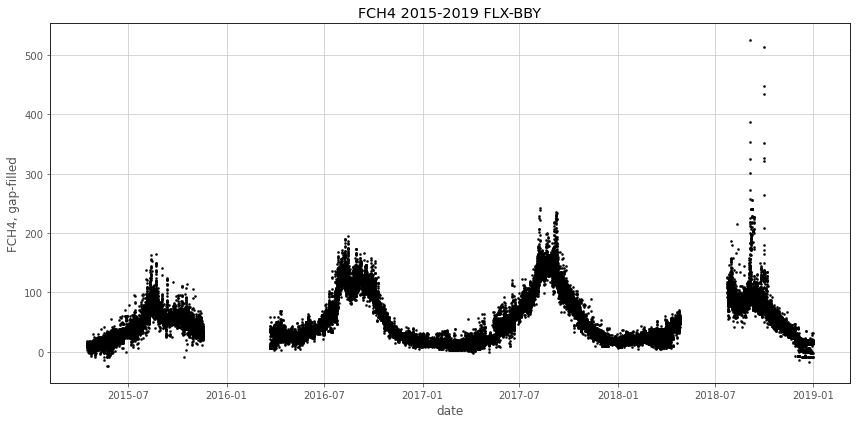

In [6]:
p.date(df.index, df['FCH4_F'], xlabel='date', ylabel='FCH4, gap-filled', title="FCH4 2015-2019 FLX-BBY")

In [7]:
windows = wave.chop(df)

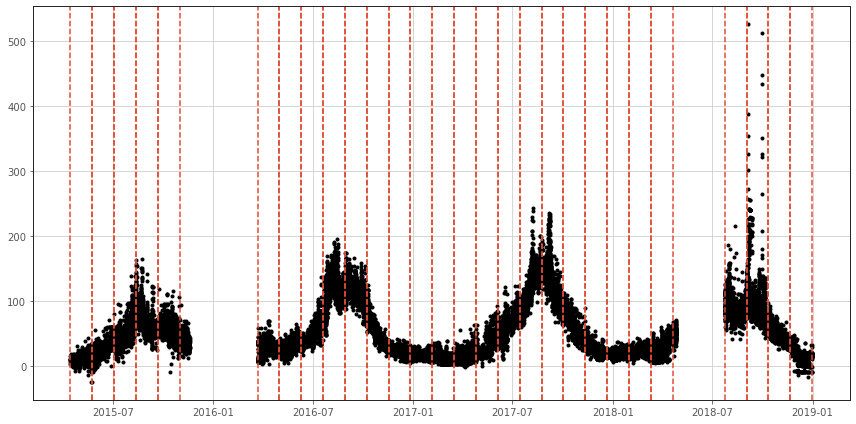

In [8]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df.index, df.loc[df.index, 'FCH4_F'], 'k.')
for w in windows:
    ax.axvline(w[0], ls='--')
    ax.axvline(w[-1], ls='--')

fig.tight_layout()

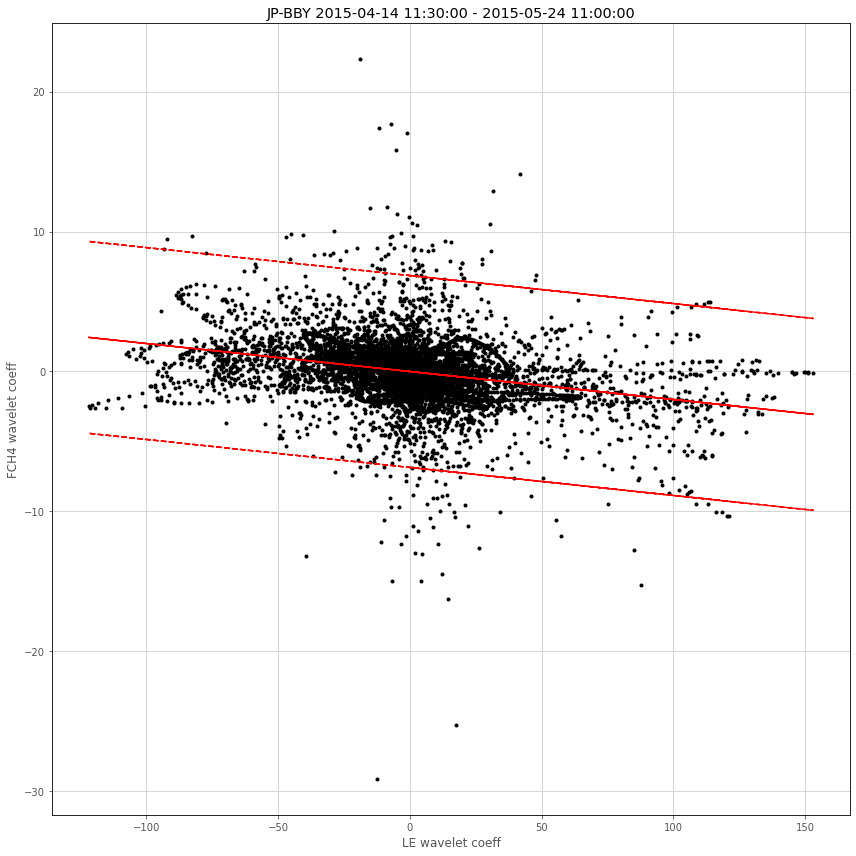

In [ ]:
# Scales lumped

for window in windows:
    dfw = df.loc[window, :]
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]

    # calc regression
    pred, rmsd, r2 = wave.get_regr_lump(dfp, Xcols, Ycols)
    
    # partition
    dfp = wave.part(dfp, pred, rmsd, r2)
    
    # lump columns to flattened arrays
    Xflat = np.concatenate(dfp[Xcols].to_numpy()).reshape(-1, 1)
    Yflat = np.concatenate(dfp[Ycols].to_numpy()).reshape(-1, 1)
        
    filename = None
#     filename = 'plot/20210716/20210716_{}_lump_iwata7_{}_{}.jpeg'.format(site_id, window[0].year, window[0].month)
    
    p.iwata7(Xflat, Yflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
           title='{} {} - {}'.format(site_id, window[0], window[-1]), 
             filename = filename)
    
    df.loc[dfw.index, 'rmsd'] = dfp.loc[:, 'rmsd'] # write back to df
    df.loc[dfw.index, 'r2'] = dfp.loc[:, 'r2'] # write back to df

In [9]:
# Scales separated

for window in windows:
    dfw = df.loc[window, :]
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]
    
    plt.close('all')
    fig, ax = plt.subplots(len(Xcols) // 2, 2, figsize=(12,12), sharex=True, sharey=True)
    
    bigax = fig.add_subplot(111, frameon=False)
    bigax.grid(False)
    bigax.tick_params(labelcolor='none', which='both', top=False, bottom=False,
                  left=False, right=False)

    bigax.set(xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
              title='{} {} - {}'.format(site_id, window[0], window[-1]))
        
    for j in range(len(Xcols)):
        
        # calc regression
        pred, rmsd, r2 = wave.get_regr(dfp, Xcols[j], Ycols[j])
        
        df.loc[dfp.index, 'pred_{}'.format(j)] = pred
        df.loc[dfp.index, 'rmsd_{}'.format(j)] = np.ones(len(dfp)) * rmsd
        df.loc[dfp.index, 'r2_{}'.format(j)] = np.ones(len(dfp)) * r2
        
        ax[j // 2, j % 2].plot(dfp[Xcols[j]], dfp[Ycols[j]], 'k.',
                               dfp[Xcols[j]], pred, 'r-', 
                               dfp[Xcols[j]], pred + 3 * rmsd, 'r--', 
                               dfp[Xcols[j]], pred - 3 * rmsd, 'r--')
    
    plt.tight_layout()

    filename = 'plot/20210719/20210719_{}_iwata7_{}_{}.jpeg'.format(site_id, window[0].year, window[0].month)
#     plt.savefig(filename)
    
    df.loc[window, Xcols] = dfp[Xcols]
    df.loc[window, Ycols] = dfp[Ycols]

    plt.close()

In [10]:
df = wave.partition(df, windows, rmsd=df.loc[windows[-2], 'rmsd_2'])

In [31]:
df.loc[df[f'ebull_0']==True].index

DatetimeIndex(['2015-07-03 15:00:00', '2015-07-03 15:30:00',
               '2015-07-03 16:00:00', '2015-07-03 16:30:00',
               '2015-07-03 17:00:00', '2015-07-03 17:30:00',
               '2015-07-03 18:00:00', '2015-07-03 18:30:00',
               '2015-07-03 19:00:00', '2015-07-03 19:30:00',
               ...
               '2018-12-16 23:30:00', '2018-12-17 00:00:00',
               '2018-12-17 00:30:00', '2018-12-17 01:00:00',
               '2018-12-17 01:30:00', '2018-12-17 02:00:00',
               '2018-12-17 02:30:00', '2018-12-17 03:00:00',
               '2018-12-17 03:30:00', '2018-12-17 04:00:00'],
              dtype='datetime64[ns]', name='date', length=9144, freq=None)

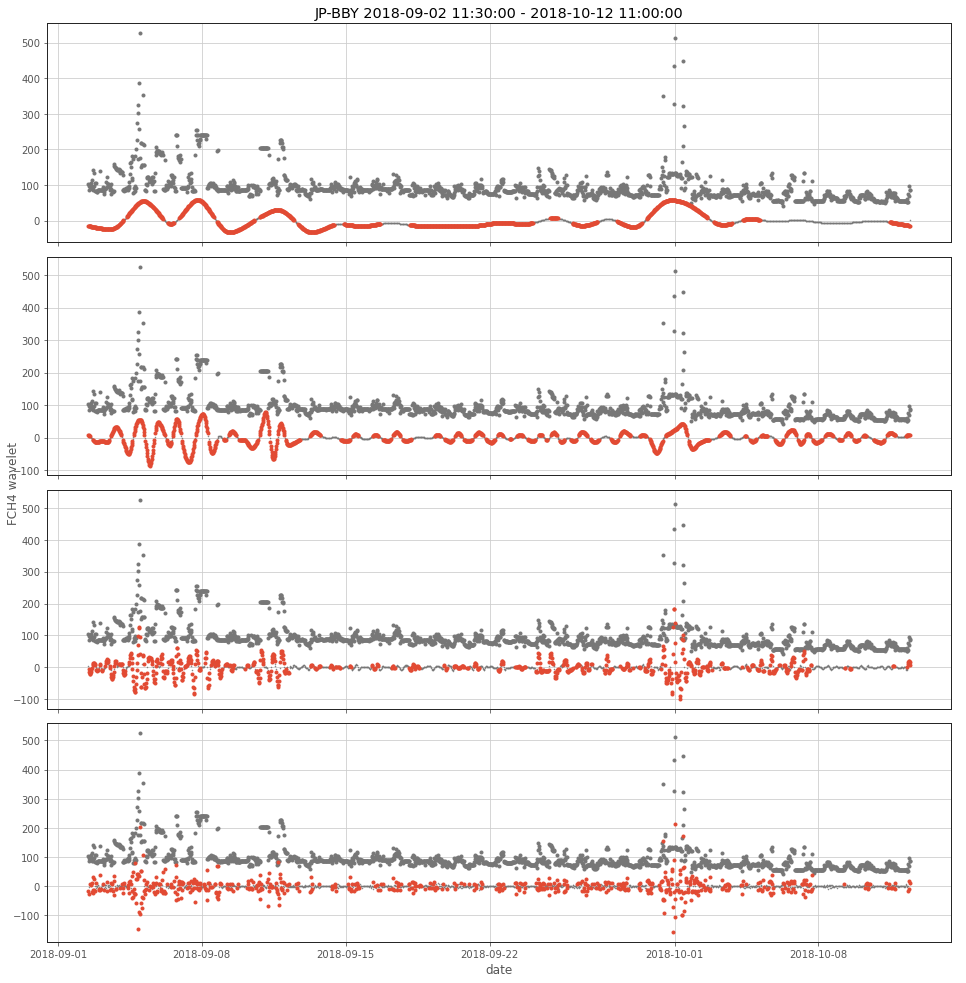

In [21]:
# Choose window and columns to plot
window = windows[-3]
dfw = df.loc[window]

cols = df.columns[df.columns.str.startswith('FCH4_w')]

# mask for ebullitive fluxes
mask = [dfw[f'ebull_{j}']==True for j in range(len(cols))]

plt.close('all')
fig, ax = plt.subplots(len(cols), 1, figsize=(14,14), sharex=True, sharey=False)

bigax = fig.add_subplot(111, frameon=False)
bigax.grid(False)
bigax.tick_params(labelcolor='none', which='both', top=False, bottom=False,
              left=False, right=False)
bigax.set(ylabel='FCH4 wavelet', title=f'{site_id} {window[0]} - {window[-1]}')

colors = list(plt.rcParams['axes.prop_cycle'])

for j in range(len(cols)):
    ax[j].plot(window, dfw[f'FCH4_F'], '.', color=colors[-1]['color'])
    ax[j].plot(window, dfw[f'FCH4_w{j}'], '.',color=colors[3]['color'], label='diffusive', markersize=1)
    ax[j].plot(dfw.loc[mask[j]].index, dfw.loc[dfw.loc[mask[j]].index, f'FCH4_w{j}'], '.', color = colors[0]['color'])
#     ax[j].plot(dfw.loc[dfw[f'ebull_{j}']==True].index, dfw.loc[dfw.loc[dfw[f'ebull_{j}']==True].index, f'FCH4_w{j}'], 'r.', label='ebullitive')

ax[-1].set(xlabel = 'date')

plt.tight_layout()
plt.show()

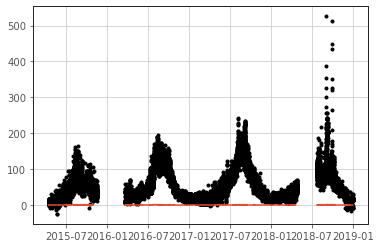

In [11]:
plt.plot(df.index, df['FCH4_F'], 'k.',
         df.index, df['ebull_0'])

In [20]:
cols = df.columns[df.columns.str.startswith('FCH4_w')]
preds = df.columns[df.columns.str.startswith('pred_')]

In [41]:
maskless = df.loc[windows[0], cols].to_numpy() < df.loc[windows[0], preds].to_numpy() + 3 * rmsd

In [19]:
dfp.loc[window, 'FCH4_w0'] > dfp.loc[window, 'pred_0'] + 3 * dfp.loc[window, 'rmsd_0']

2018-11-21 10:30:00     True
2018-11-21 11:00:00    False
2018-11-21 11:30:00    False
2018-11-21 12:00:00    False
2018-11-21 12:30:00    False
                       ...  
2018-12-31 08:00:00    False
2018-12-31 08:30:00    False
2018-12-31 09:00:00    False
2018-12-31 09:30:00    False
2018-12-31 10:00:00    False
Freq: 30T, Length: 1920, dtype: bool

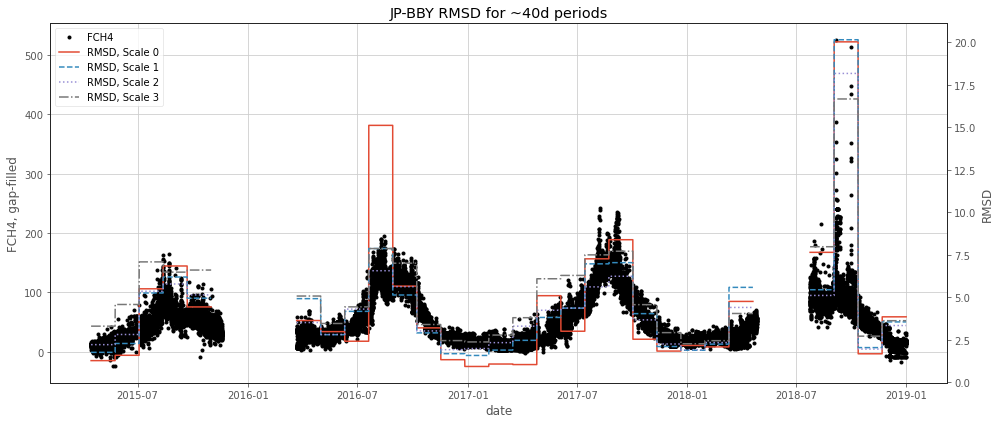

In [12]:
filename = f'plot/20210719/20210719_{site_id}_sep_rmsd_vs_date.jpeg'
p.date_rmsd(df, title = f'{site_id} RMSD for ~40d periods', 
            filename = filename,
            figsize=(14,6)
           )

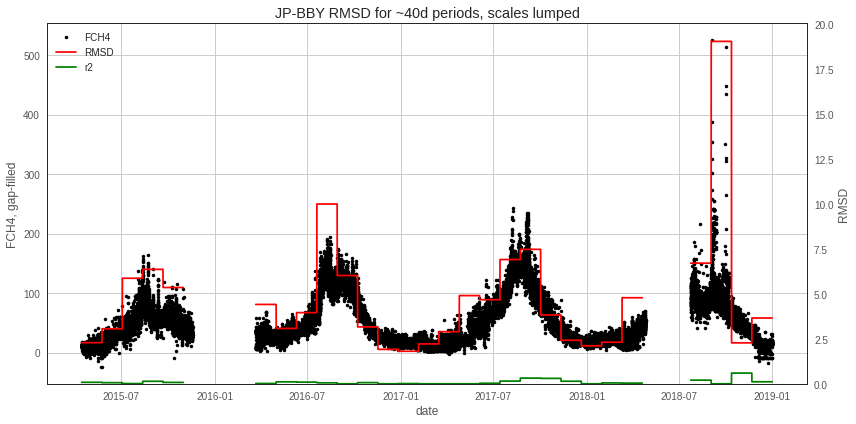

In [92]:
p.date_rmsd_lump(df, title = '{} RMSD for ~40d periods, scales lumped'.format(site_id),
                 filename='plot/20210716/20210716_{}_lump_rmsd_vs_date.jpeg'.format(site_id))

## 6 month intervals

In [3]:
# df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame
# df = wave.read('FLX_JP-BBY', method='url')
df = wave.read('FLX_JP-BBY', method='file')

In [4]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

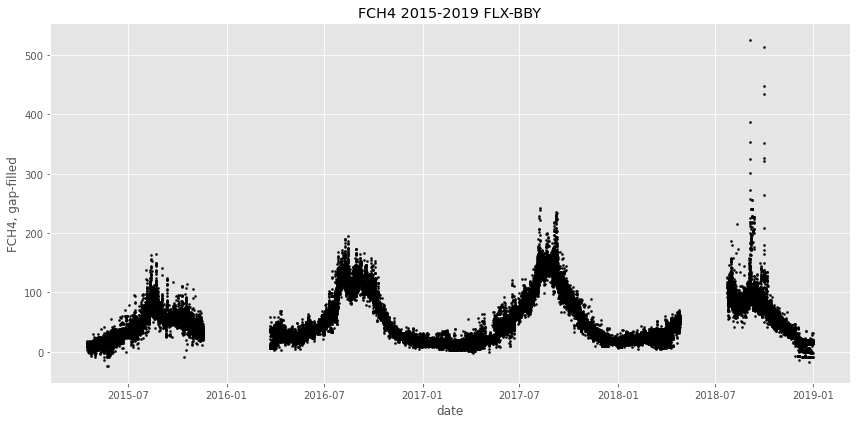

In [5]:
p.date(df.index, df['FCH4_F'], xlabel='date', ylabel='FCH4, gap-filled', title="FCH4 2015-2019 FLX-BBY")

In [6]:
date_ranges = [pd.date_range(start, stop, freq='30min') for [start, stop] in [['2015-01', '2015-07'], 
                                                                        ['2015-07', '2016-01'], 
                                                                        ['2016-01', '2016-07'], 
                                                                        ['2016-07', '2017-01'], 
                                                                        ['2017-01', '2017-07'], 
                                                                        ['2017-07', '2018-01'], 
                                                                        ['2018-01', '2018-07'], 
                                                                        ['2018-07', '2018-12-30']]]

In [7]:
idates = [df.loc[date_range, 'FCH4_F'].notna().index for date_range in date_ranges] #convert date ranges to indices, ignoring missing data

In [8]:
for idate in idates:
    dfw = df.loc[idate, :]
    dfw = dfw.loc[dfw['FCH4'].first_valid_index():dfw['FCH4'].last_valid_index()]
    
#     dfp = wave.wave(dfw) # process to new df
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]
    
    # calc regression
    pred, [Xflat, Yflat], rmsd, r2 = wave.get_regr(dfp, Xcols, Ycols)
    
    # partition
    dfp = wave.part(dfp, pred, rmsd, r2)
    
#     p.iwata7(Xflat, Yflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
#            title='{} - {}'.format(idate[0], idate[-1]), 
#              filename = 'plot/20210714_iwata7_{}_{}.jpeg'.format(idate[0].year, idate[0].month))
    
    df.loc[dfw.index, 'rmsd'] = dfp.loc[:, 'rmsd'] # write back to df
    df.loc[dfw.index, 'r2'] = dfp.loc[:, 'r2'] # write back to df


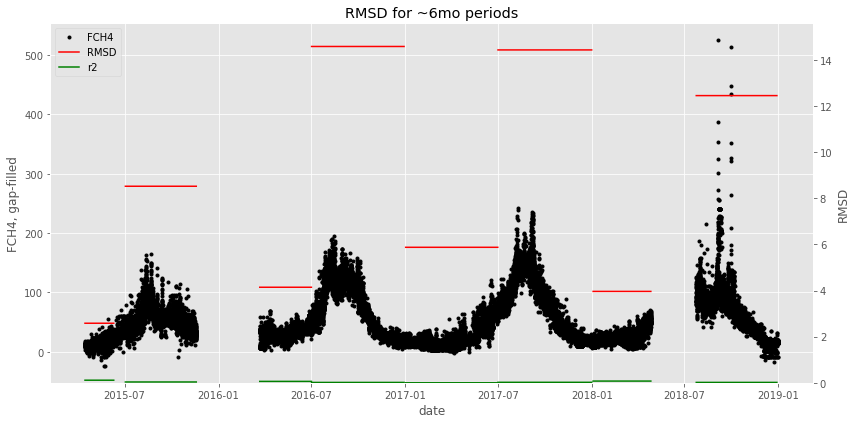

In [9]:
fig, ax = plt.subplots(figsize = (12,6))

ax.plot(df.index, df.loc[:, 'FCH4_F'], 'k.', label='FCH4')
ax.set(xlabel = 'date', ylabel = 'FCH4, gap-filled', title = 'RMSD for ~6mo periods')

axr = ax.twinx()
axr.grid(False)
axr.yaxis.set_label_position('right')
axr.yaxis.tick_right()
axr.plot(df.index, df.loc[:, 'rmsd'], 'r-', label='RMSD')
axr.plot(df.index, df.loc[:, 'r2'], 'g-', label='r2')
axr.set_ylim([0, df.loc[:, 'rmsd'].max() + 1])
axr.set_ylabel('RMSD')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
linesr, labelsr = axr.get_legend_handles_labels()
ax.legend(lines + linesr, labels + labelsr, loc=2)

plt.tight_layout()
# plt.savefig('plot/20210709_rmsd_vs_date.jpeg')

## 2 month intervals

In [3]:
# df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame
# df = wave.read('FLX_JP-BBY', method='url')

In [3]:
site_id = 'JP-BBY'

In [4]:
df = wave.read('FLX_{}'.format(site_id), method='file')

In [5]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

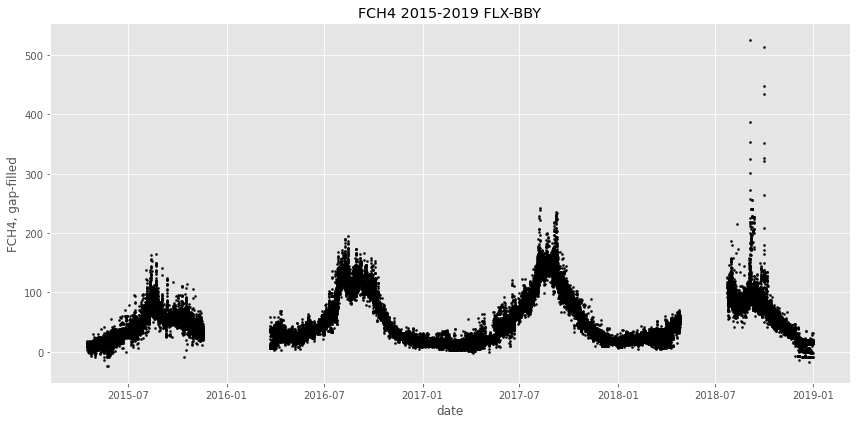

In [6]:
p.date(df.index, df['FCH4_F'], xlabel='date', ylabel='FCH4, gap-filled', title="FCH4 2015-2019 FLX-BBY")

In [7]:
windows = wave.chop(df)

appending window 2015-04-14 11:30:00 to 2015-05-24 11:00:00 to windows
appending window 2015-05-24 11:00:00 to 2015-07-03 10:30:00 to windows
appending window 2015-07-03 10:30:00 to 2015-08-12 10:00:00 to windows
appending window 2015-08-12 10:00:00 to 2015-09-21 09:30:00 to windows
appending window 2015-09-21 09:30:00 to 2015-10-31 09:00:00 to windows
window 2015-10-31 09:00:00 to 2015-12-10 08:30:00 contains missing data
appending window 2016-03-21 17:00:00 to 2016-04-30 16:30:00 to windows
appending window 2016-04-30 16:30:00 to 2016-06-09 16:00:00 to windows
appending window 2016-06-09 16:00:00 to 2016-07-19 15:30:00 to windows
appending window 2016-07-19 15:30:00 to 2016-08-28 15:00:00 to windows
appending window 2016-08-28 15:00:00 to 2016-10-07 14:30:00 to windows
appending window 2016-10-07 14:30:00 to 2016-11-16 14:00:00 to windows
appending window 2016-11-16 14:00:00 to 2016-12-26 13:30:00 to windows
appending window 2016-12-26 13:30:00 to 2017-02-04 13:00:00 to windows
appen

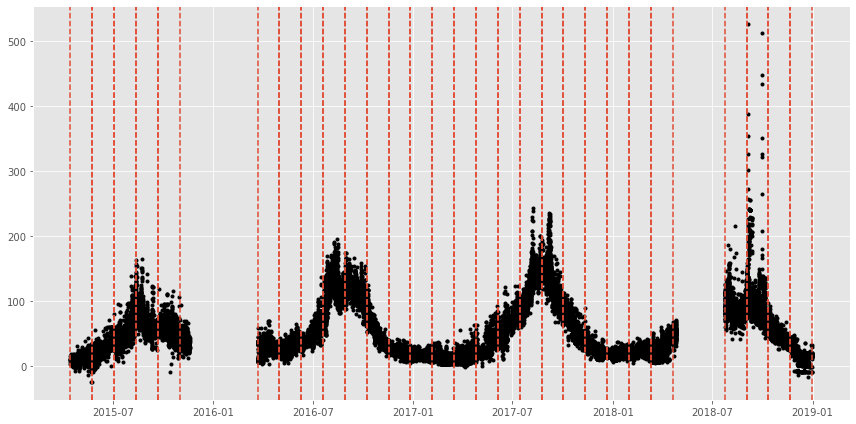

In [8]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df.index, df.loc[df.index, 'FCH4_F'], 'k.')
for w in windows:
    ax.axvline(w[0], ls='--')
    ax.axvline(w[-1], ls='--')

fig.tight_layout()

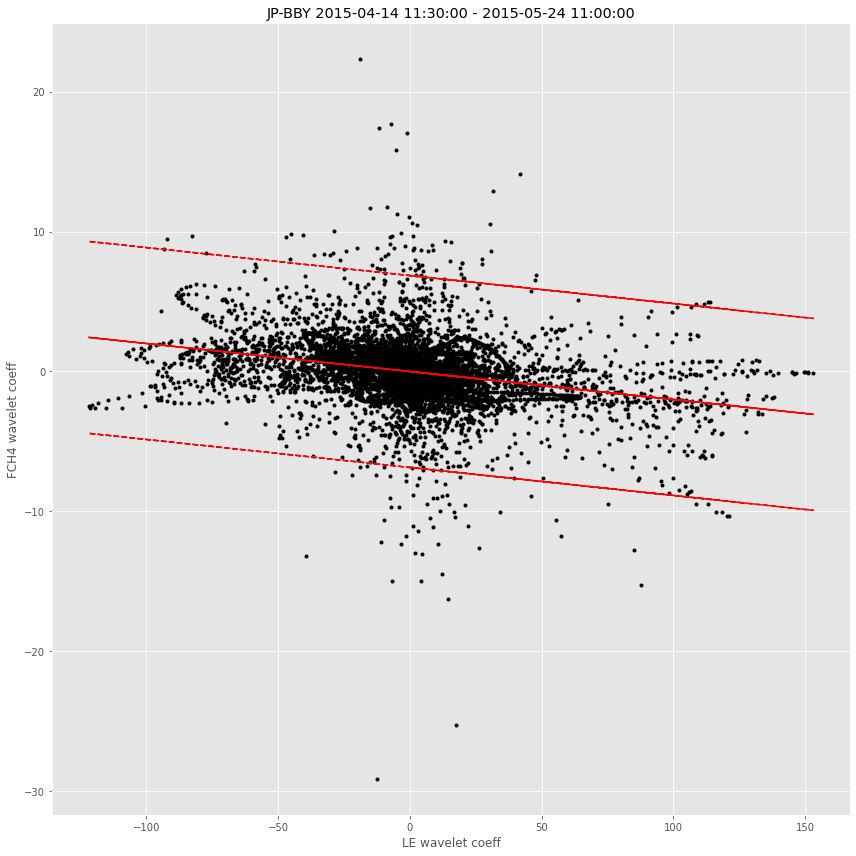

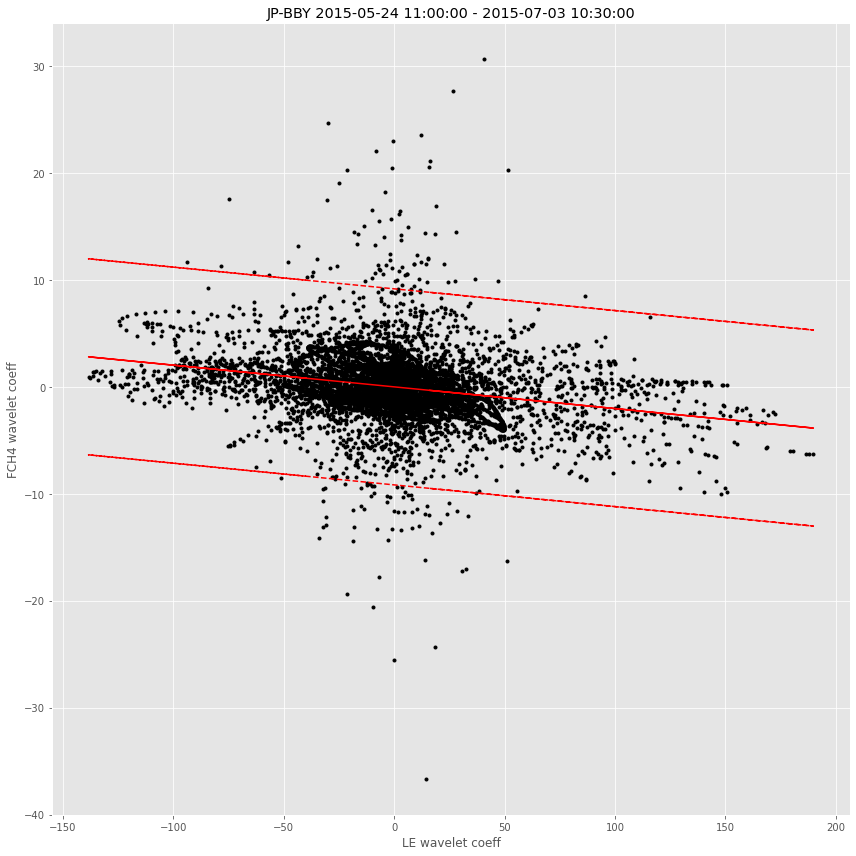

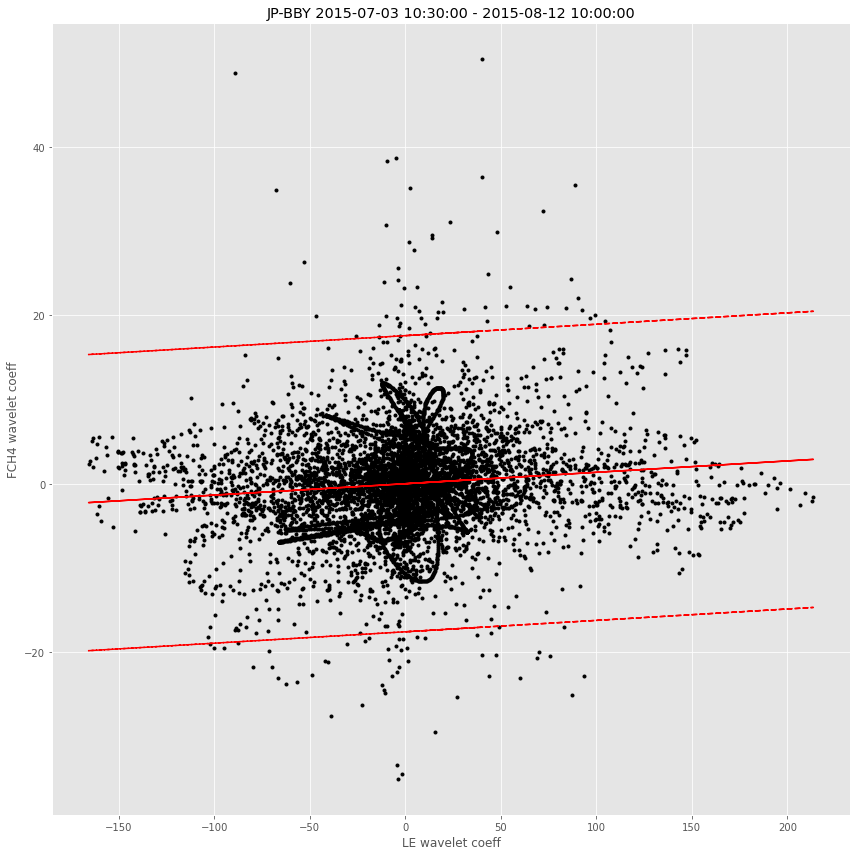

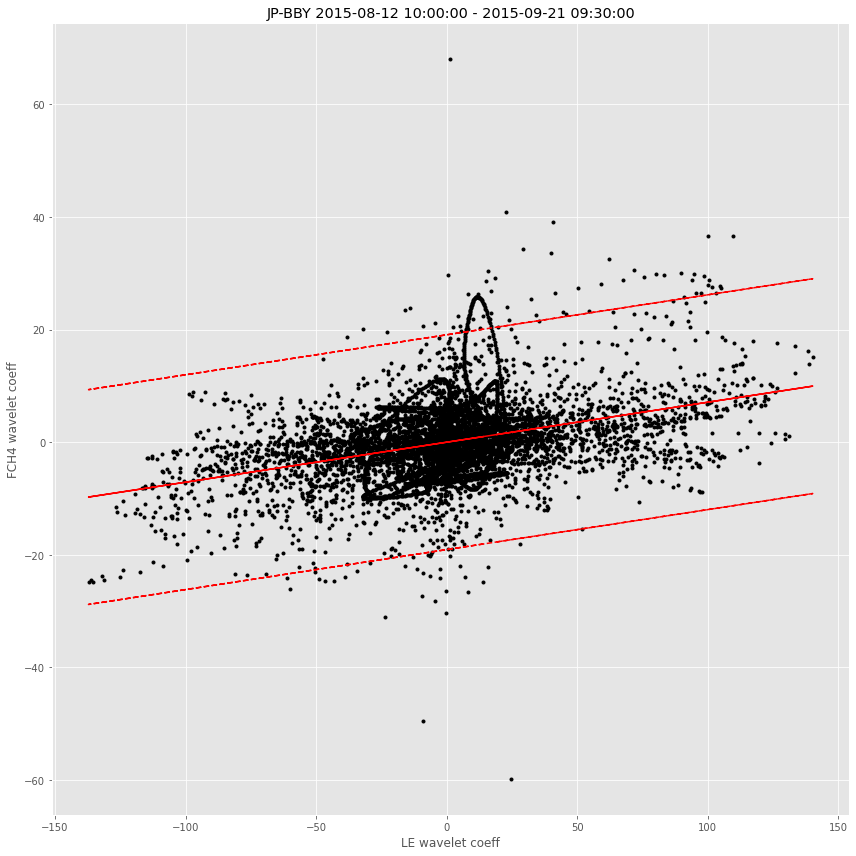

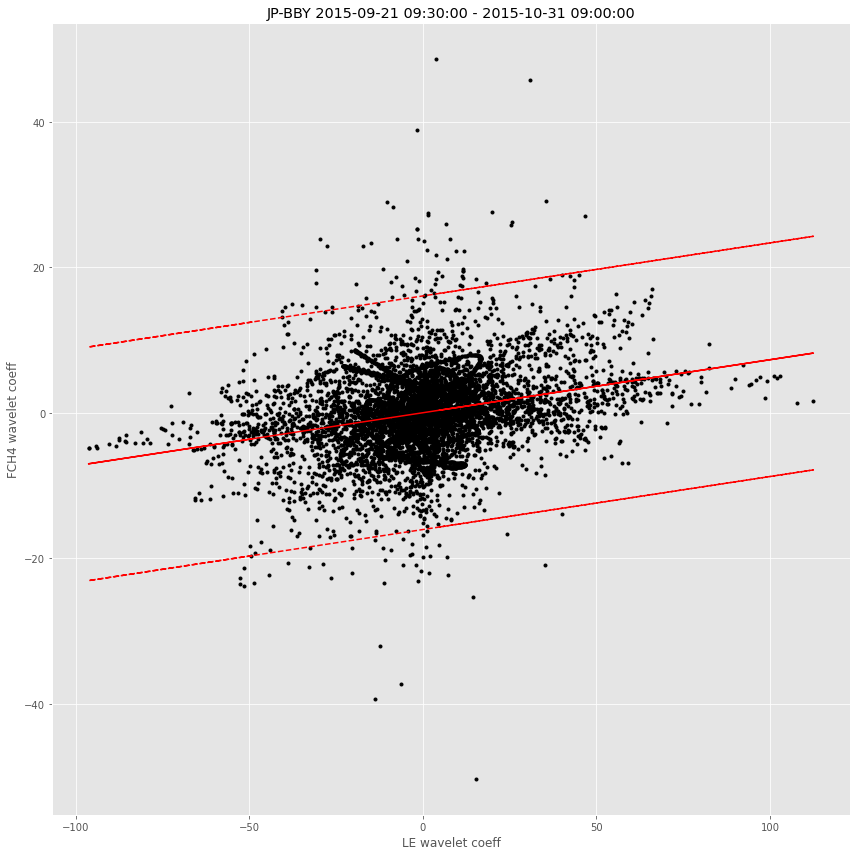

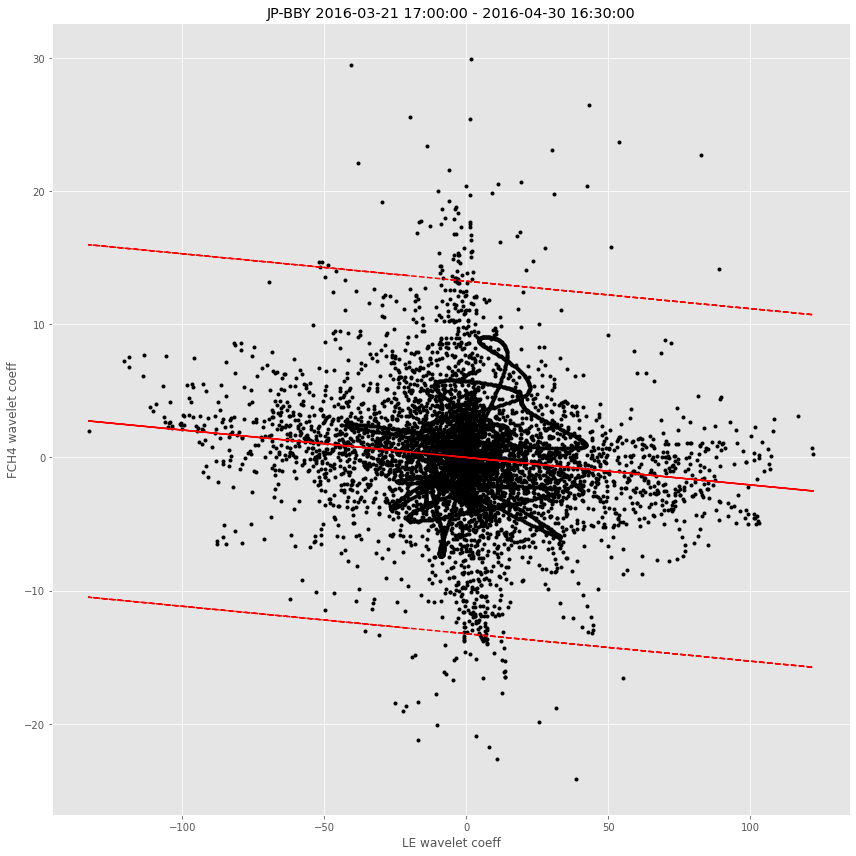

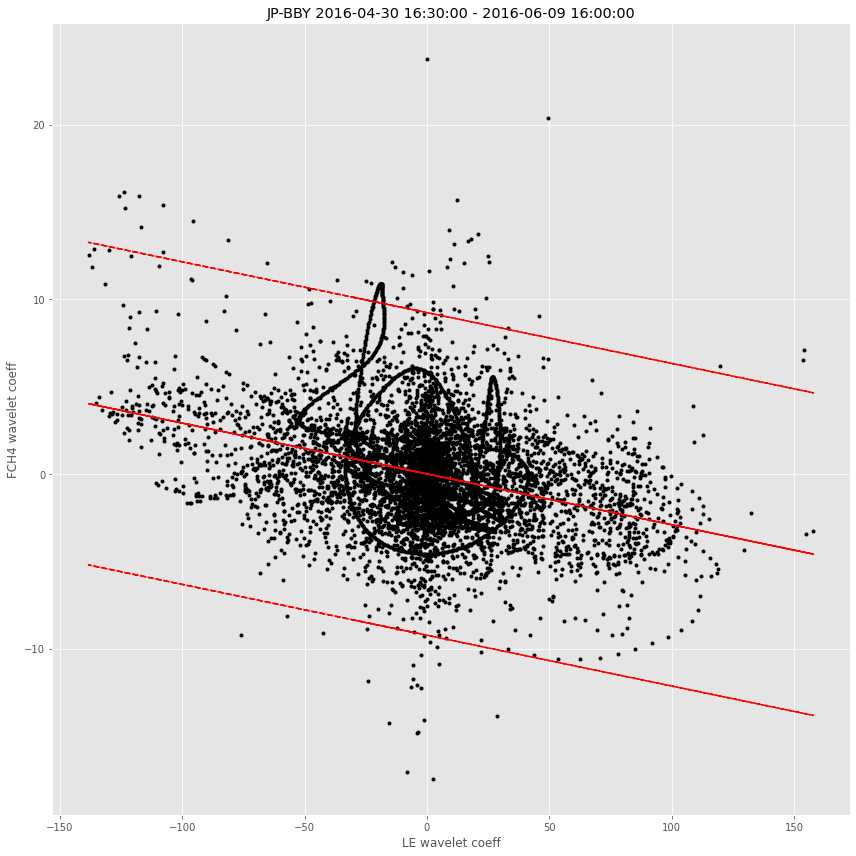

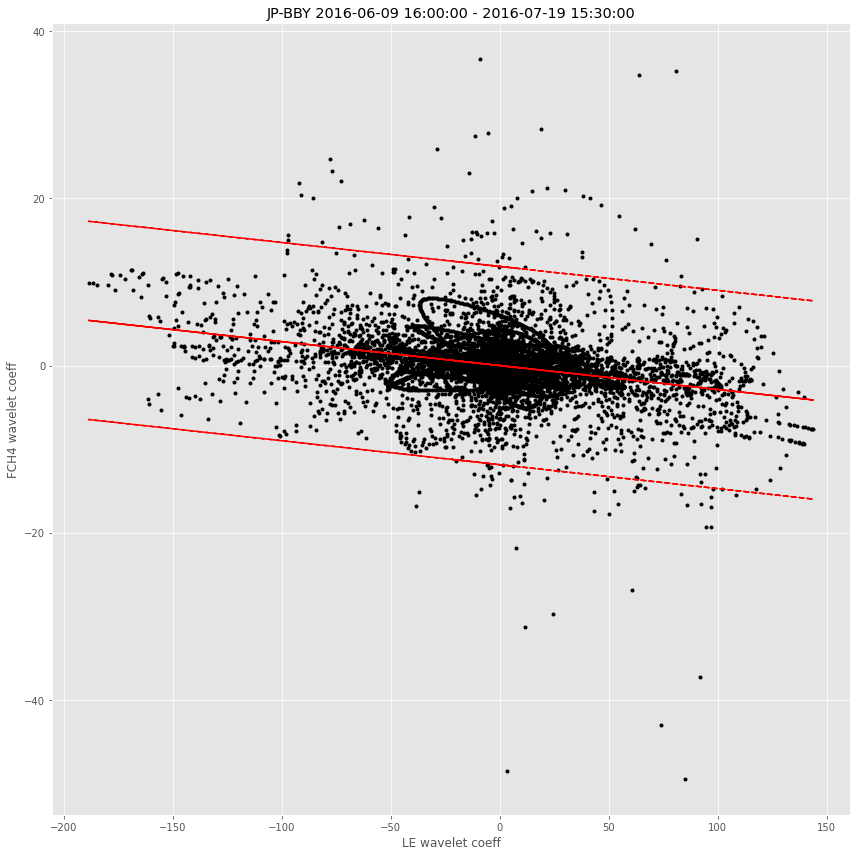

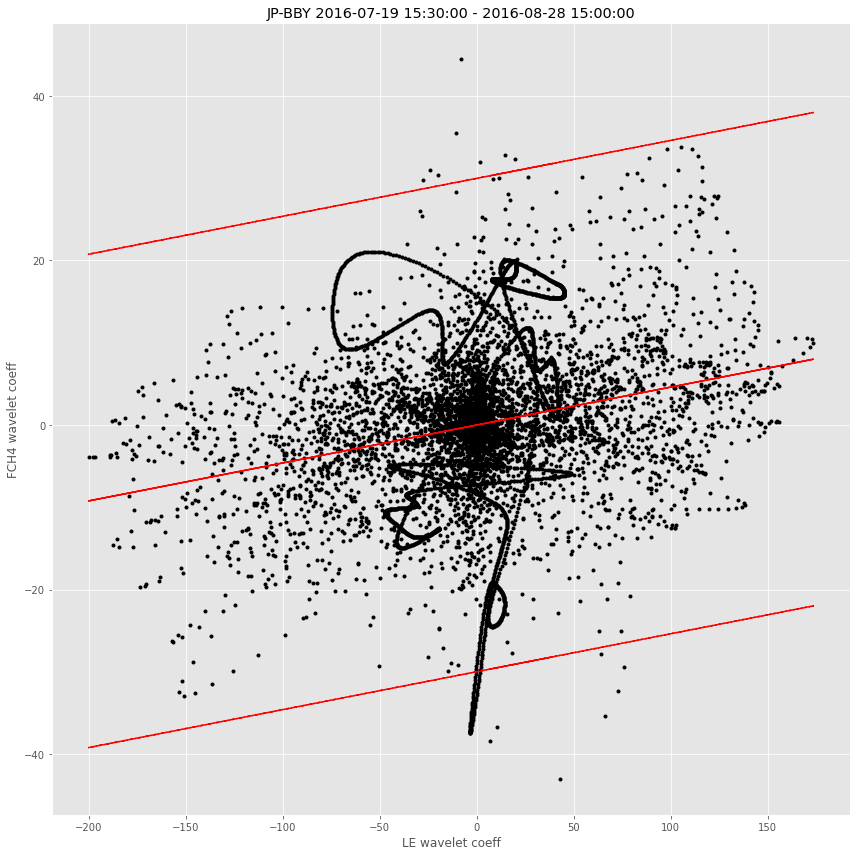

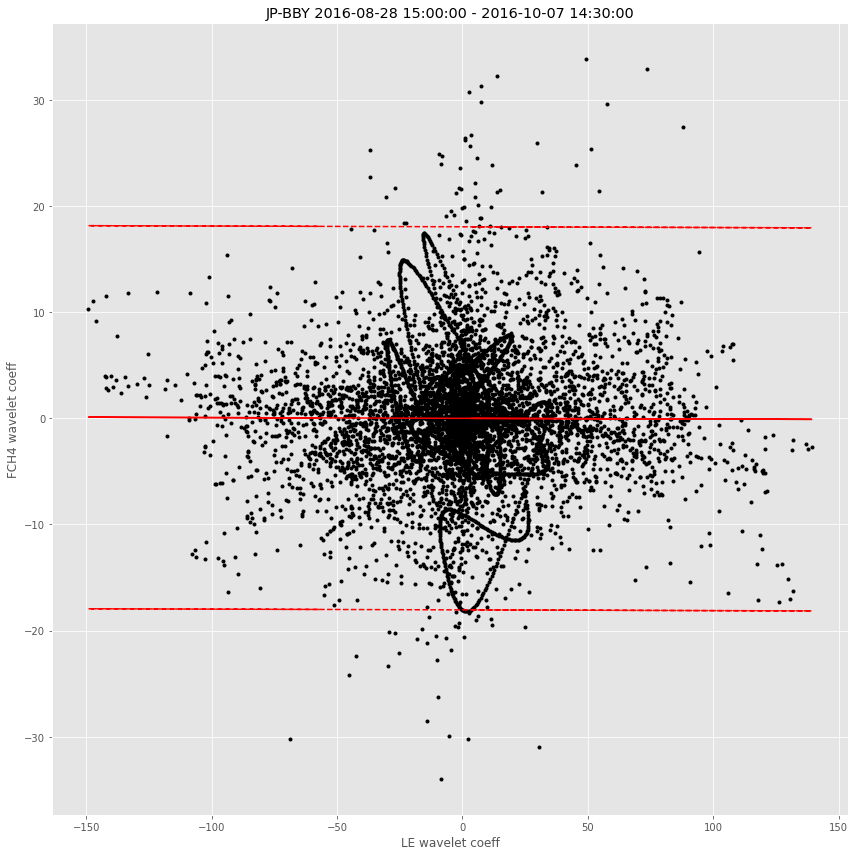

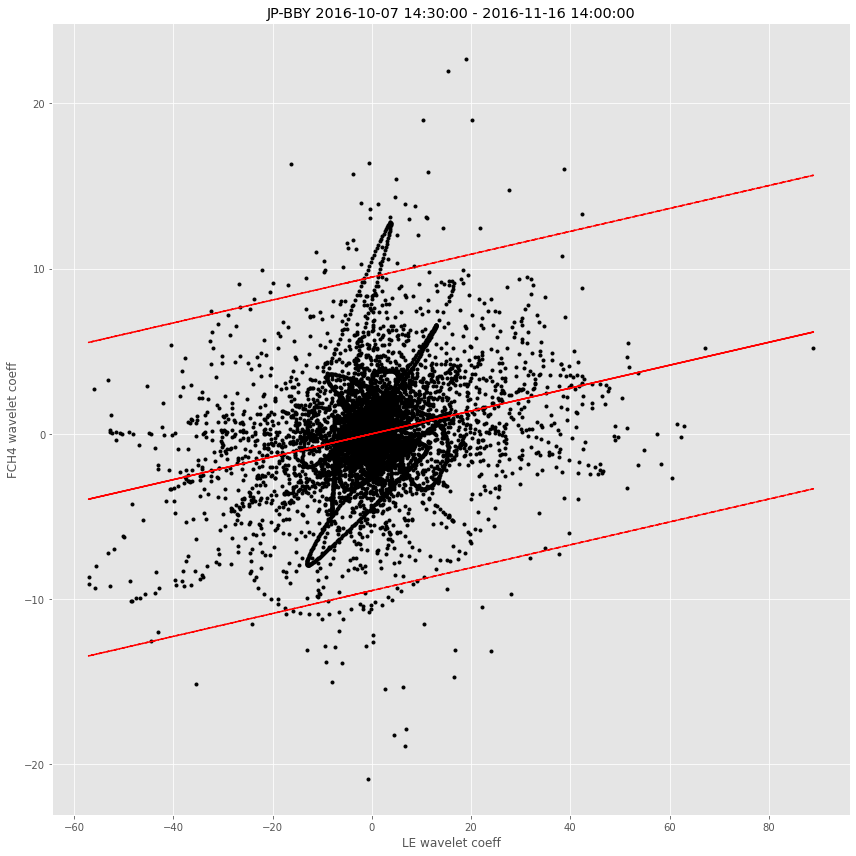

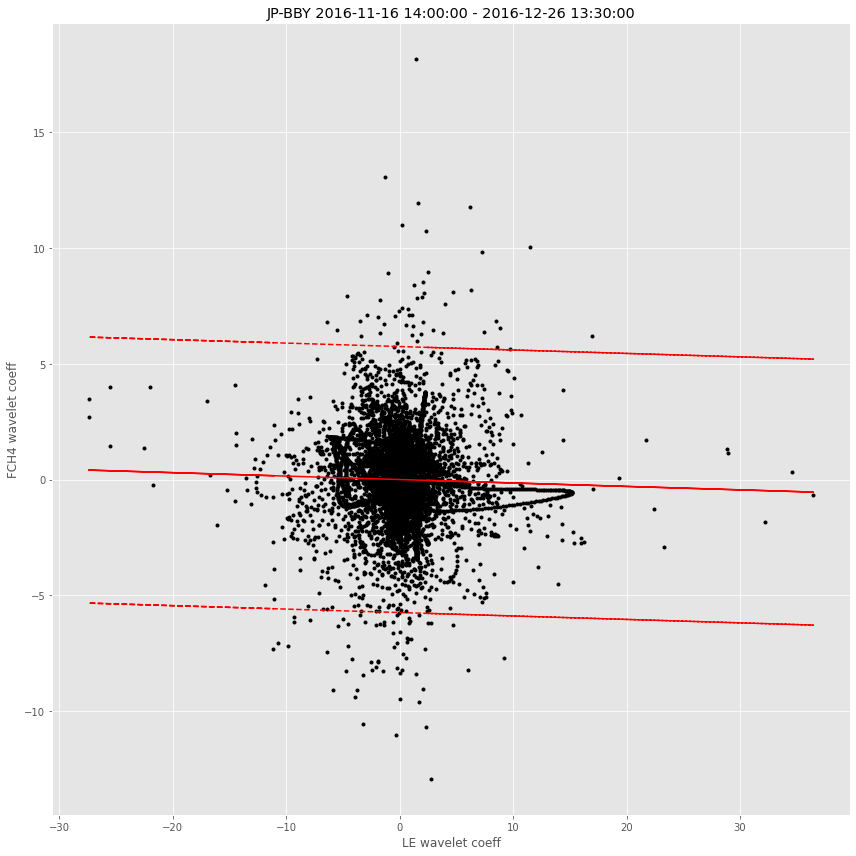

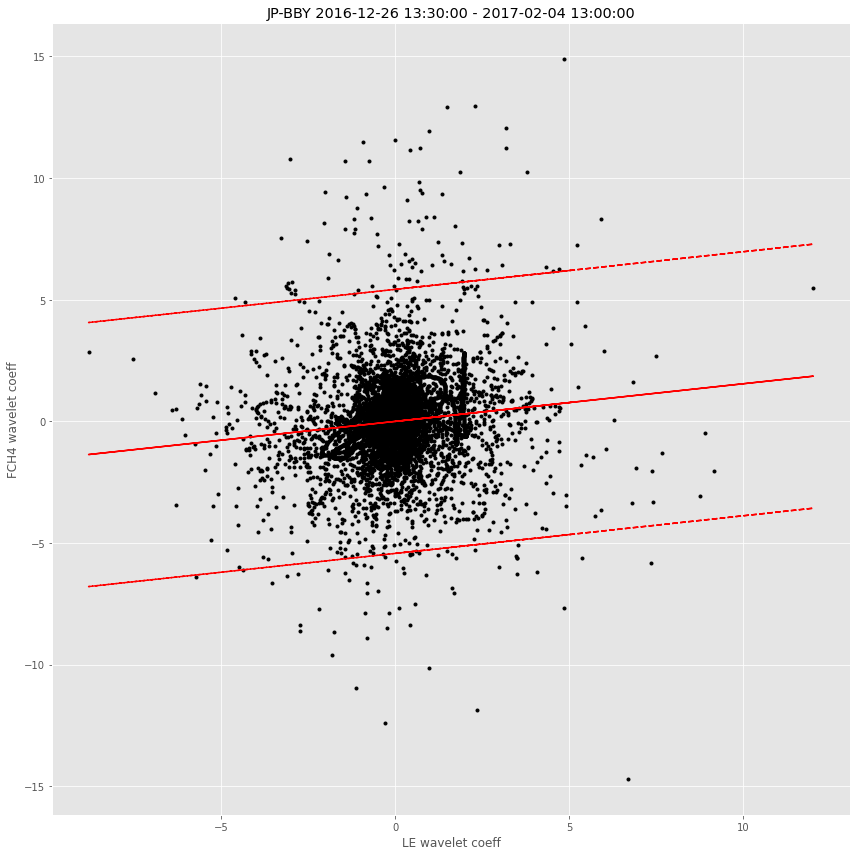

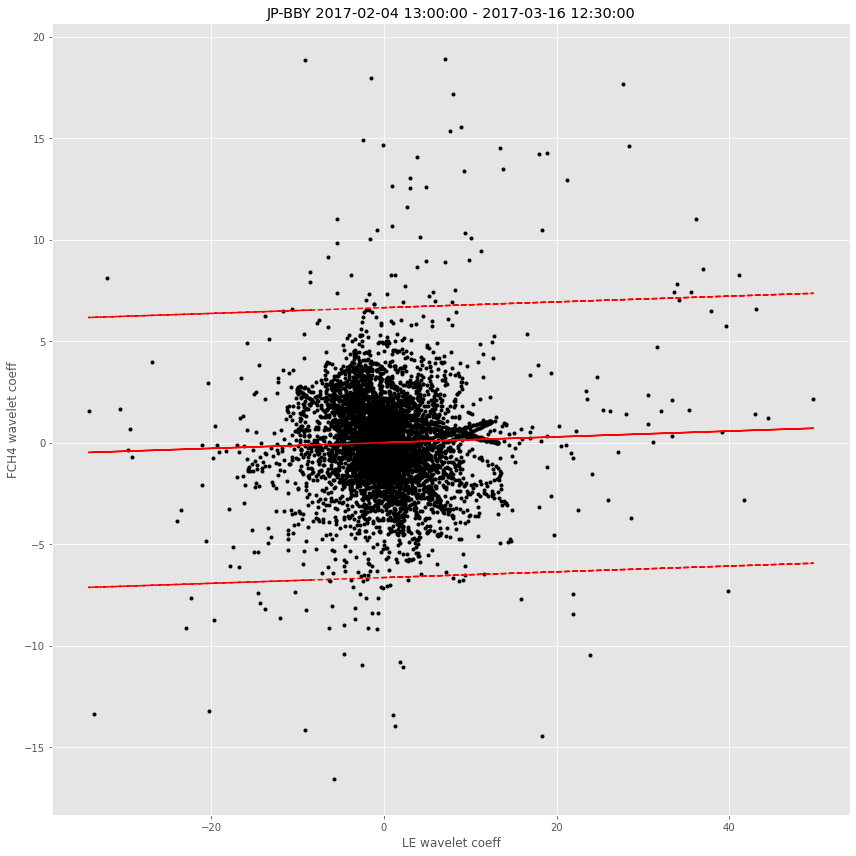

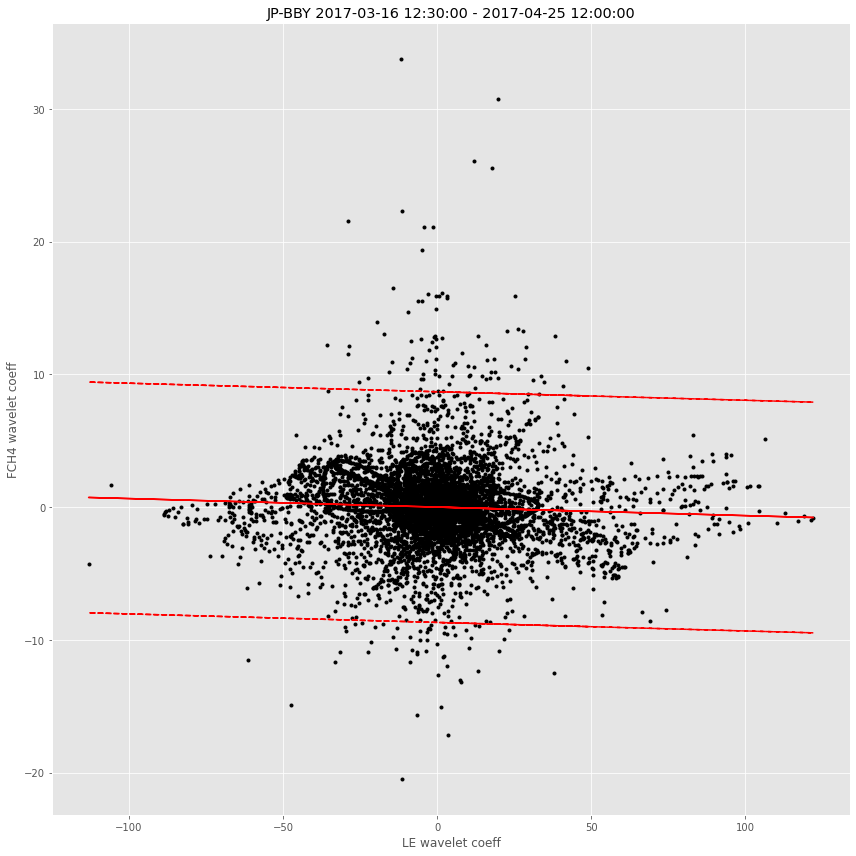

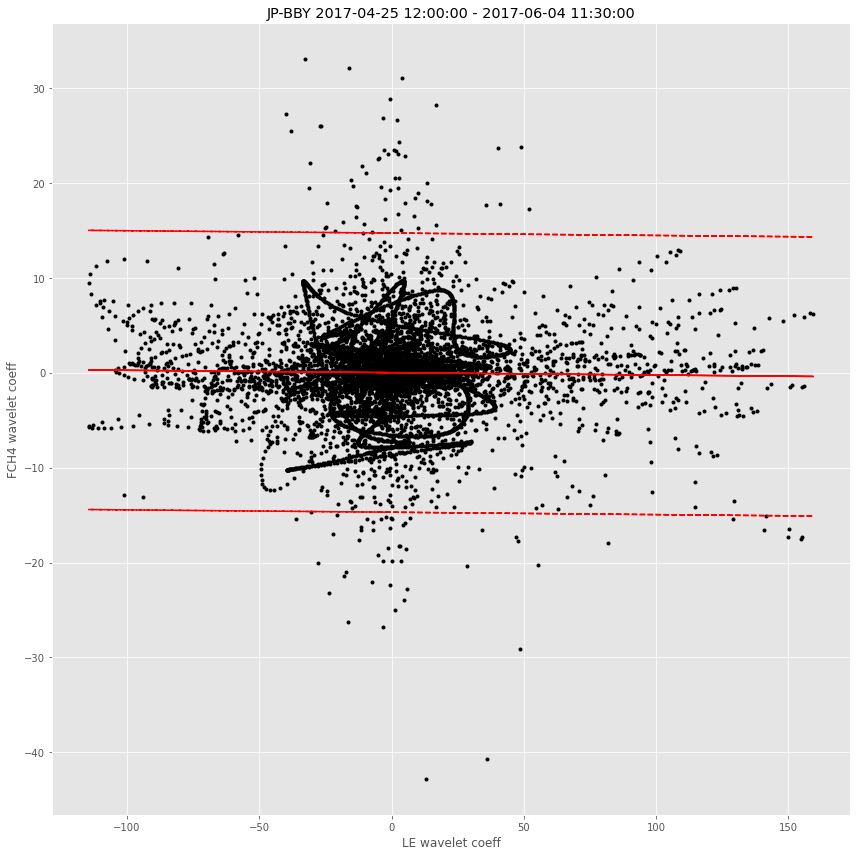

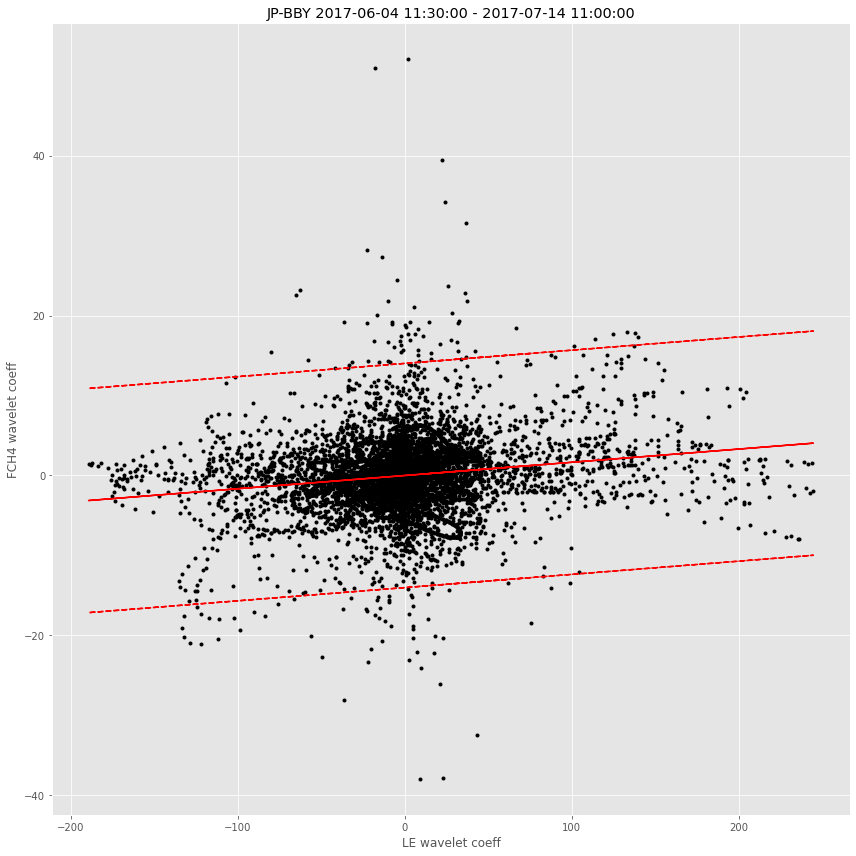

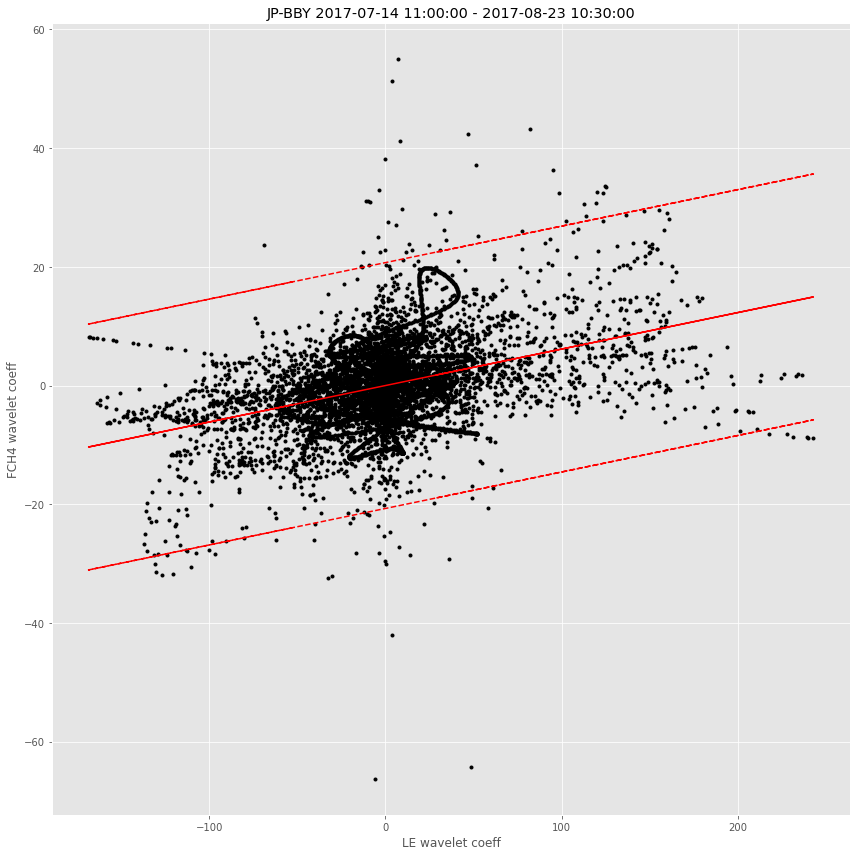

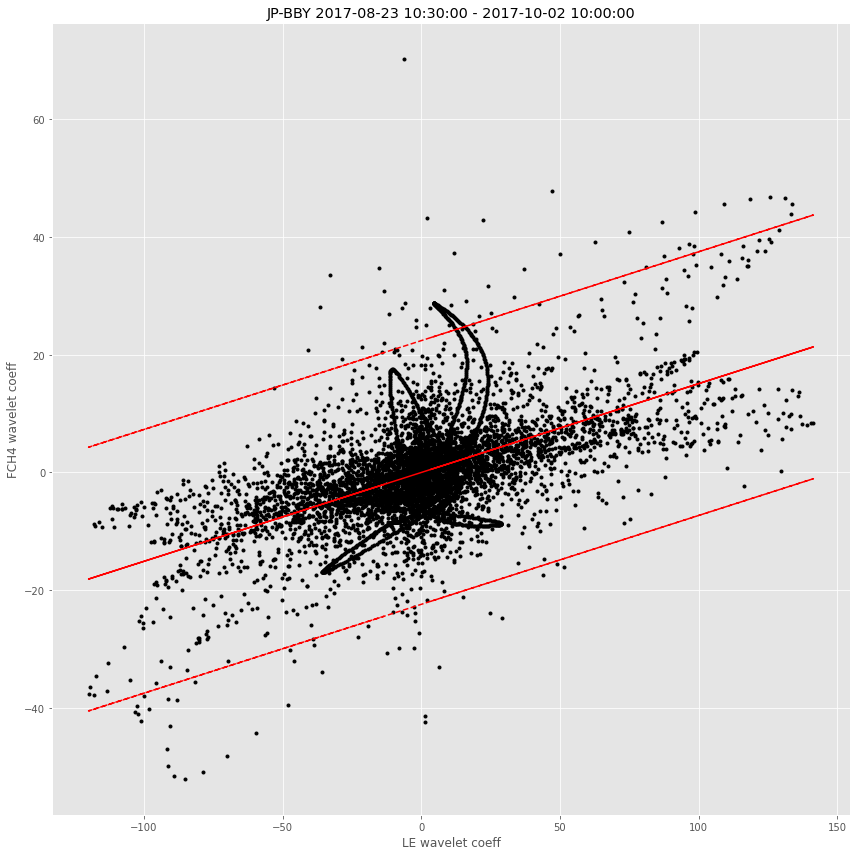

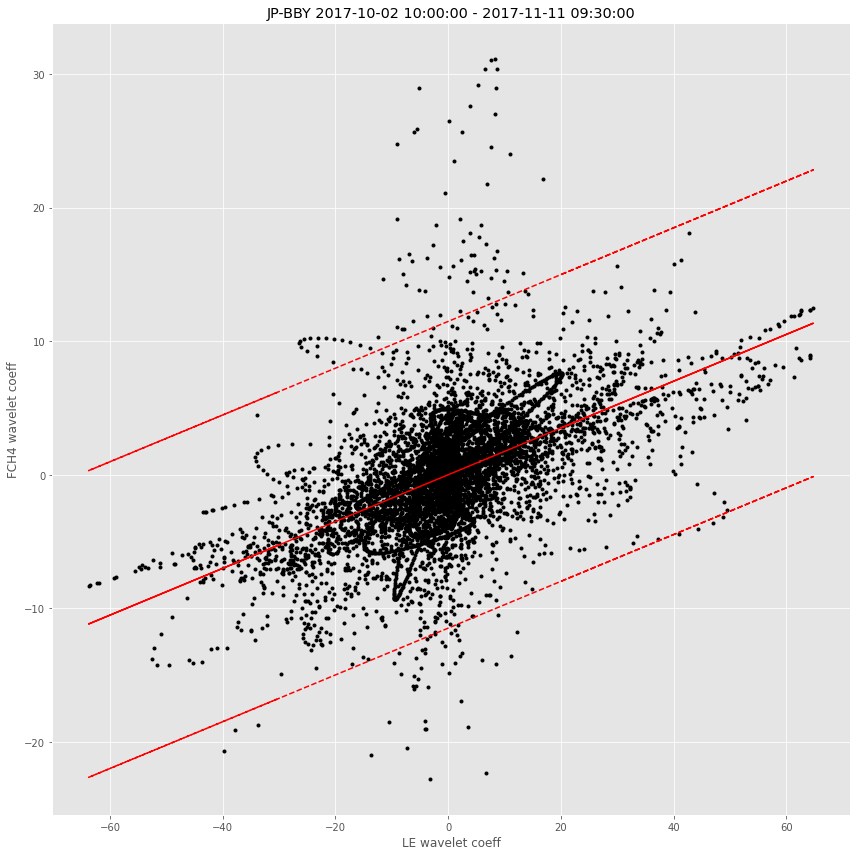

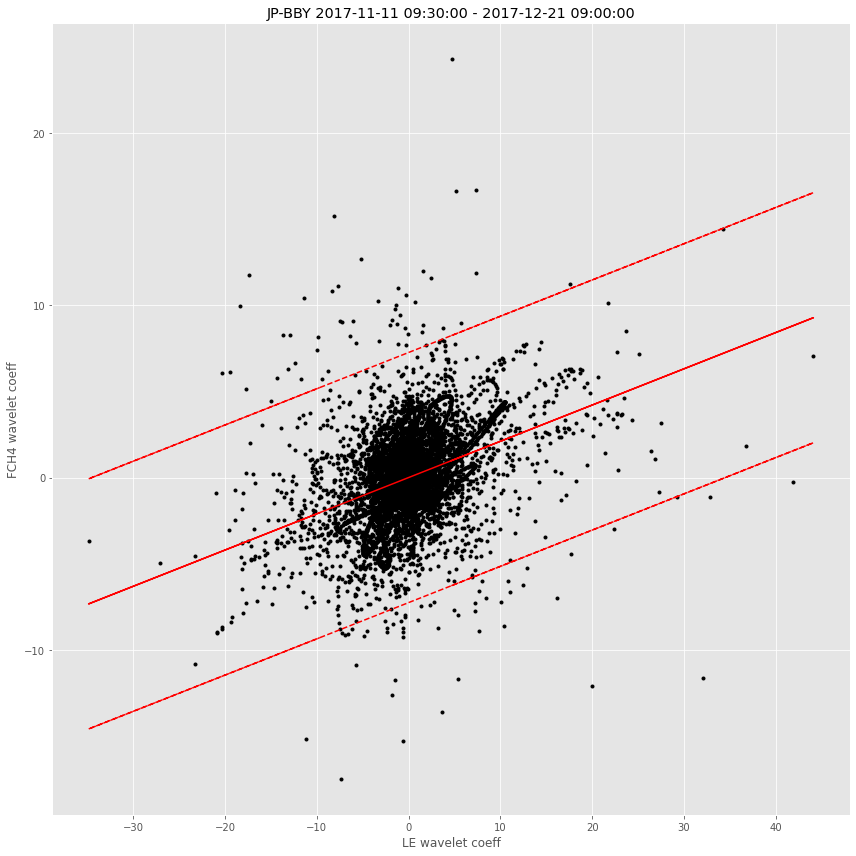

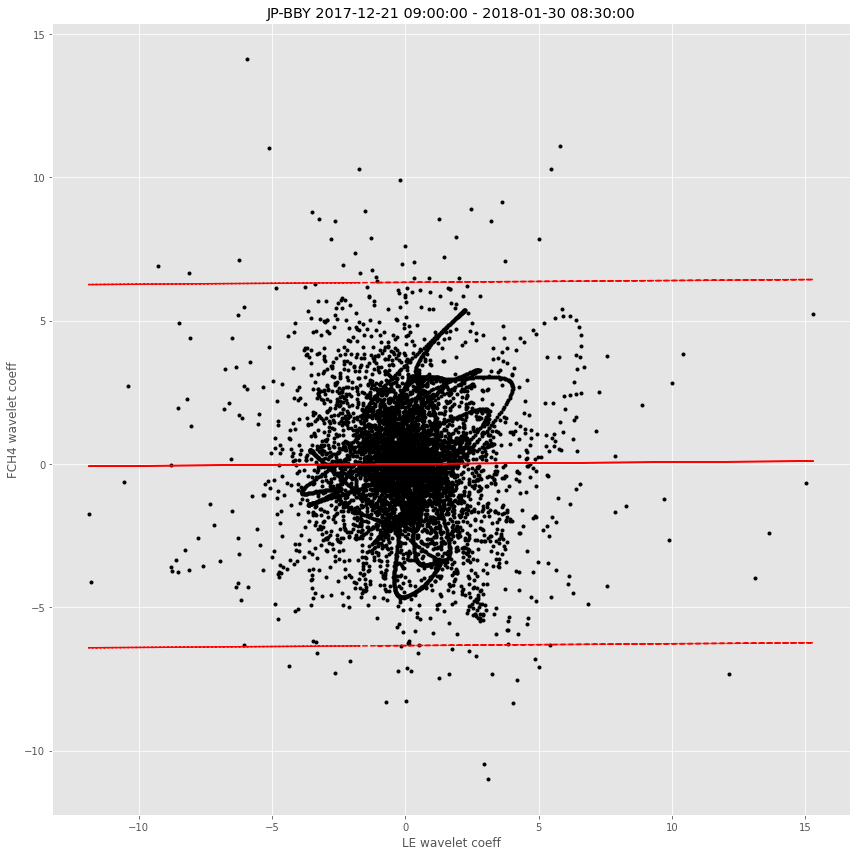

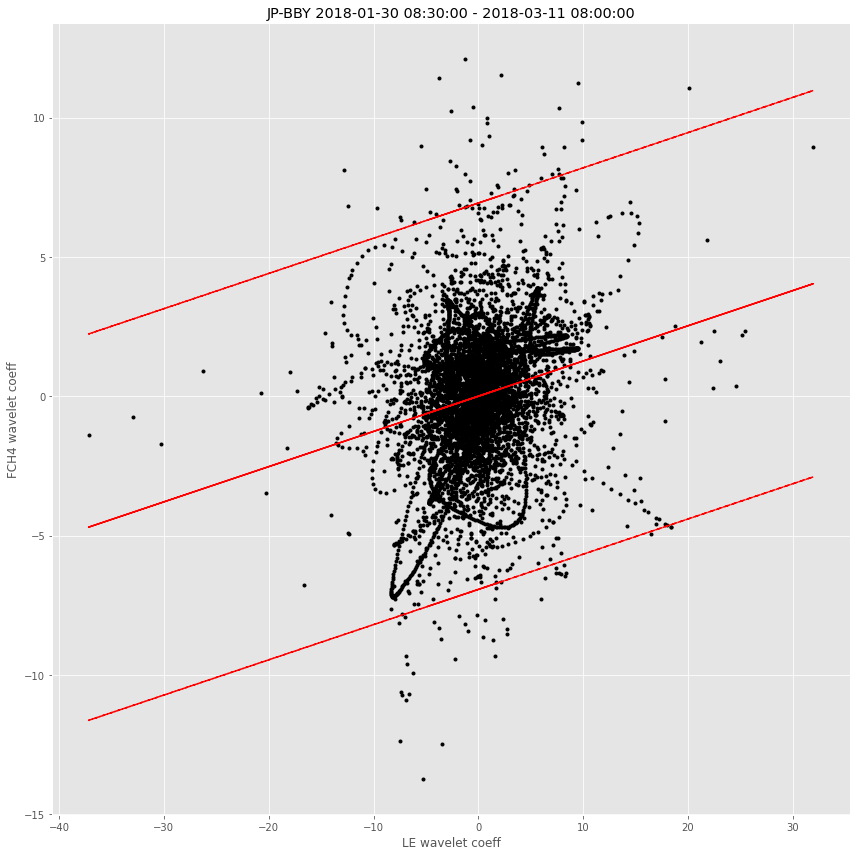

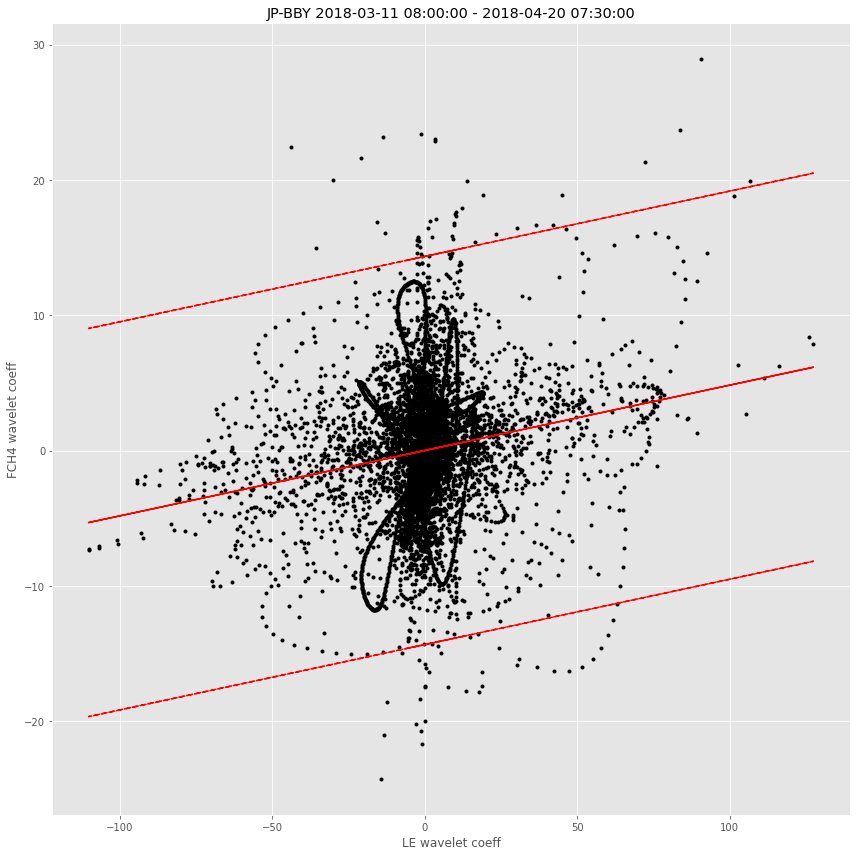

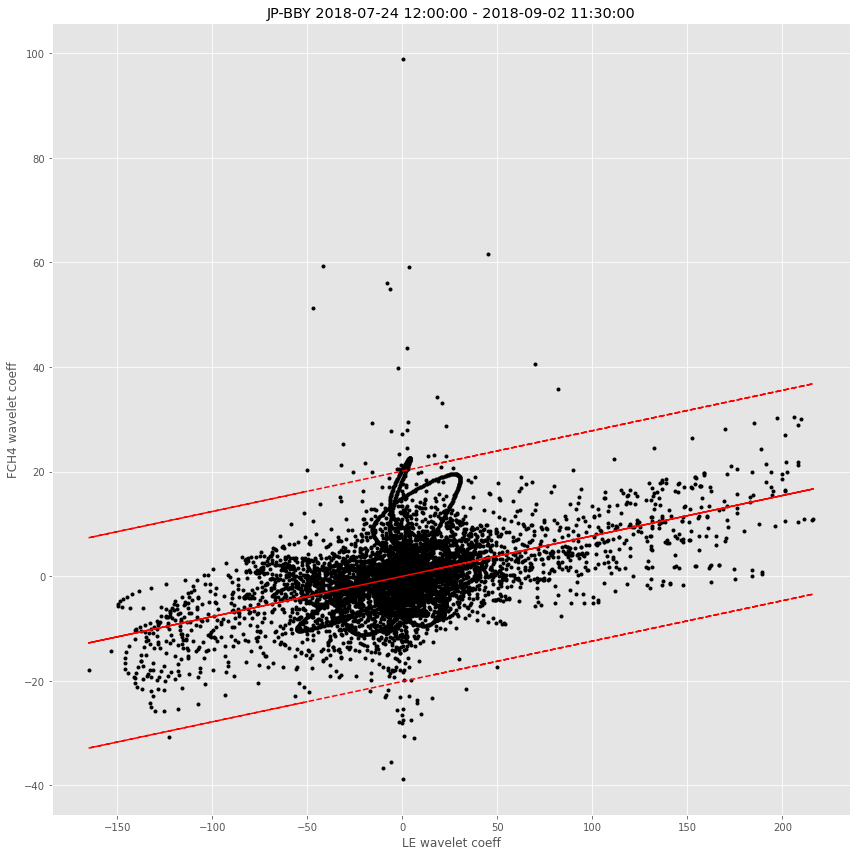

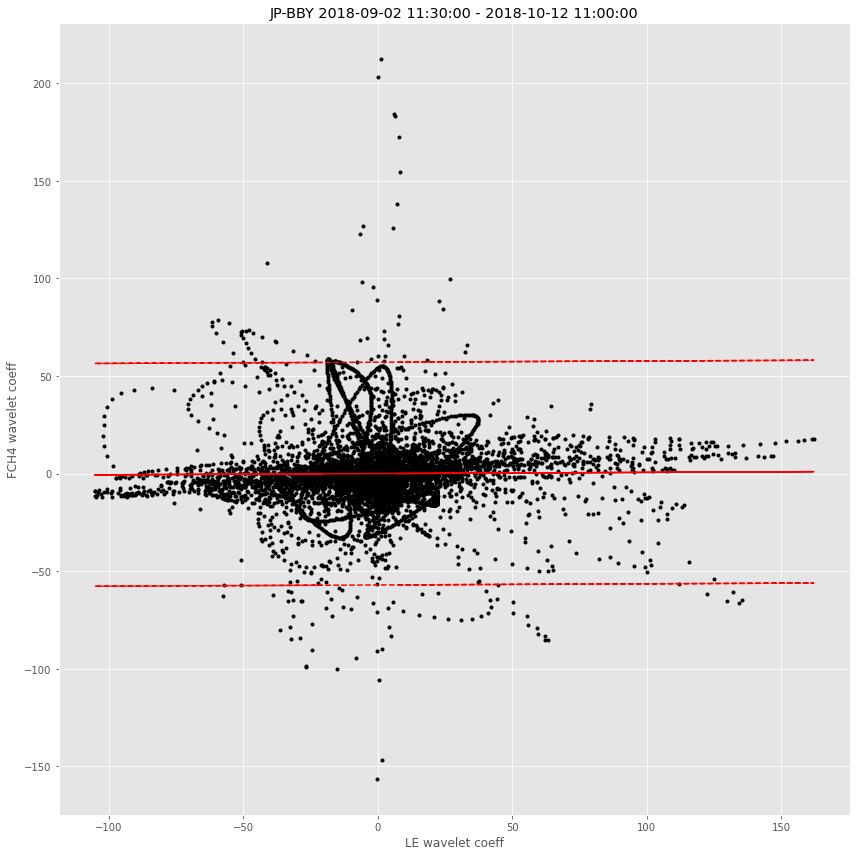

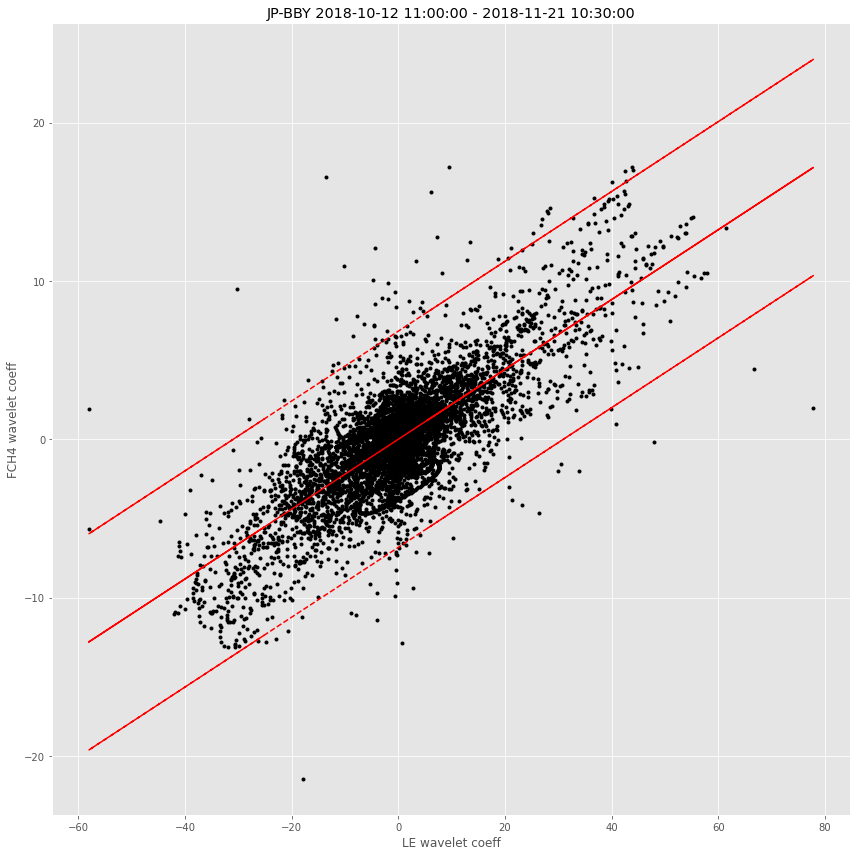

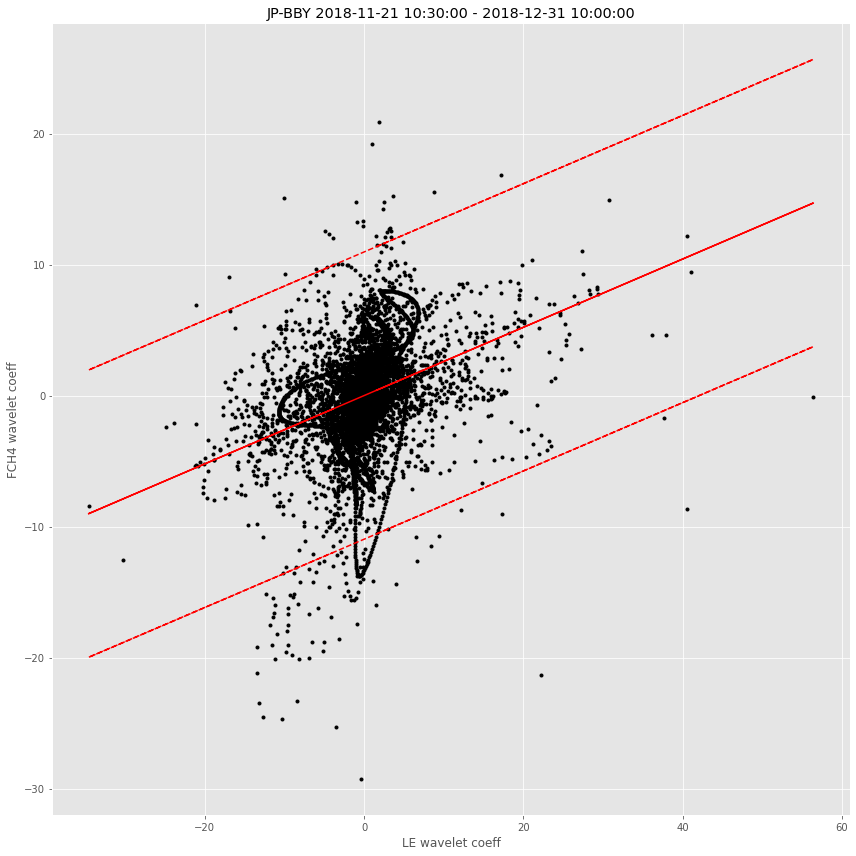

In [10]:
# Scales lumped

for window in windows:
    dfw = df.loc[window, :]
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]
    
    # calc regression
    pred, [Xflat, Yflat], rmsd, r2 = wave.get_regr(dfp, Xcols, Ycols)
    
    Xflat = np.concatenate(dfp[Xcols].to_numpy()).reshape(-1, 1)
    Yflat = np.concatenate(dfp[Ycols].to_numpy()).reshape(-1, 1)

    
    # partition
    dfp = wave.part(dfp, pred, rmsd, r2)
    
#     filename = None
    filename = 'plot/20210716/20210716_{}_lump_iwata7_{}_{}.jpeg'.format(site_id, window[0].year, window[0].month)
    
    p.iwata7(Xflat, Yflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
           title='{} {} - {}'.format(site_id, window[0], window[-1]), 
             filename = filename)
    
    df.loc[dfw.index, 'rmsd'] = dfp.loc[:, 'rmsd'] # write back to df
    df.loc[dfw.index, 'r2'] = dfp.loc[:, 'r2'] # write back to df

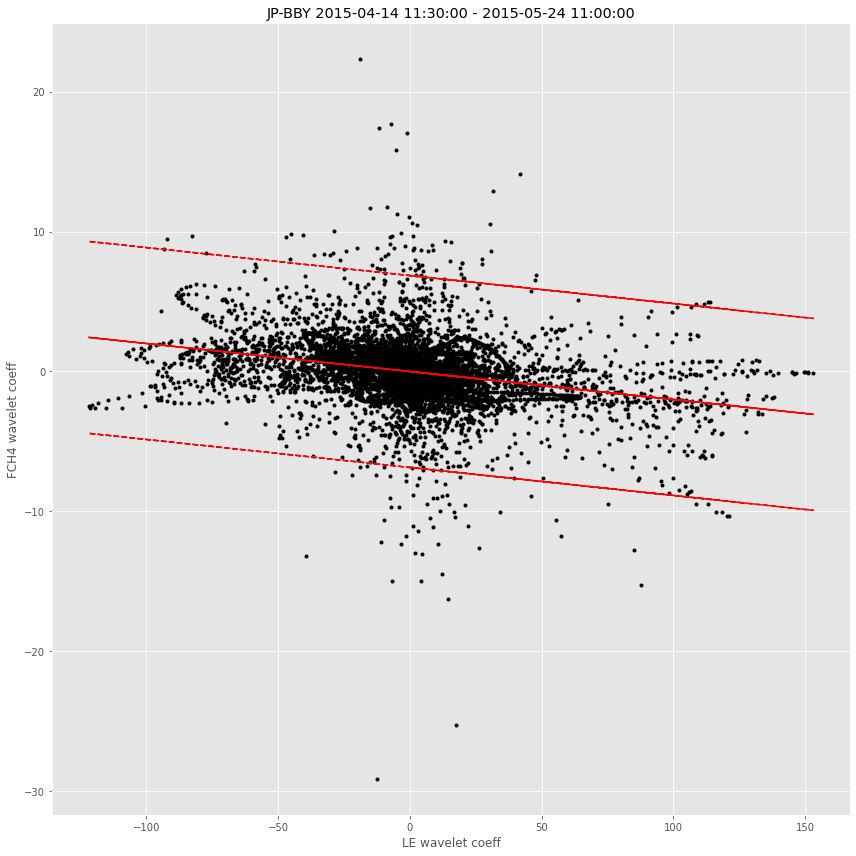

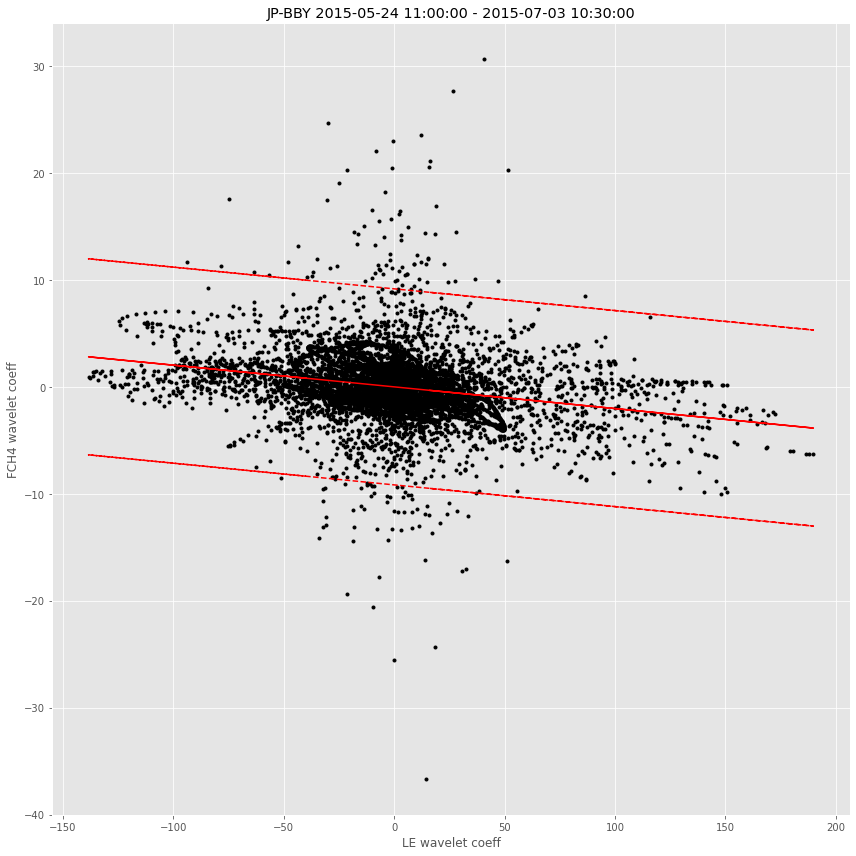

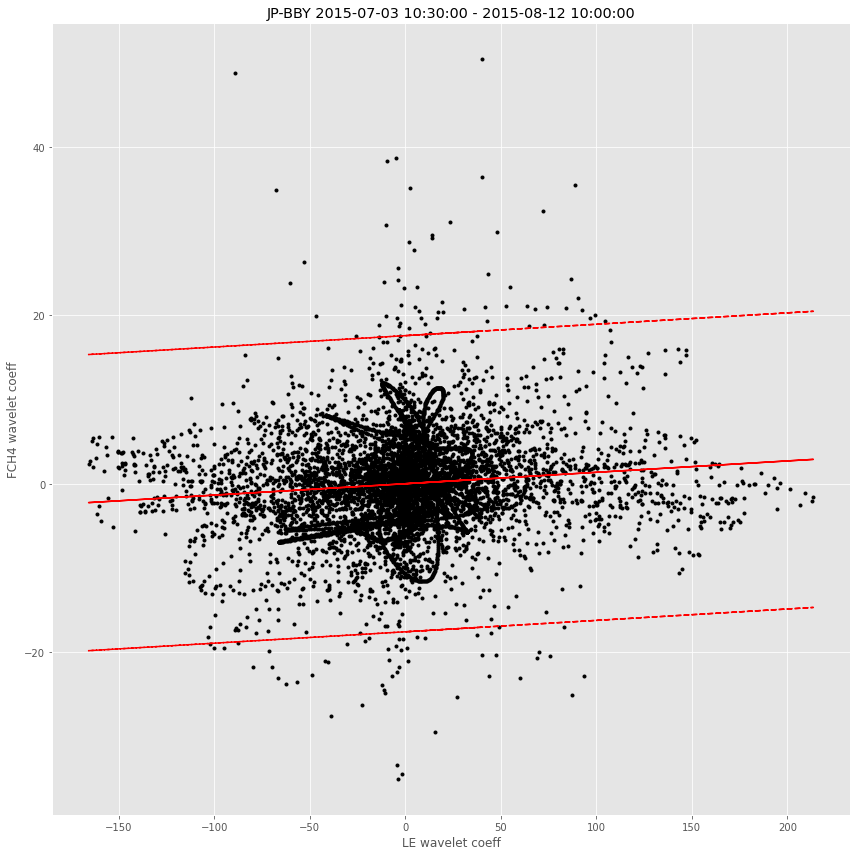

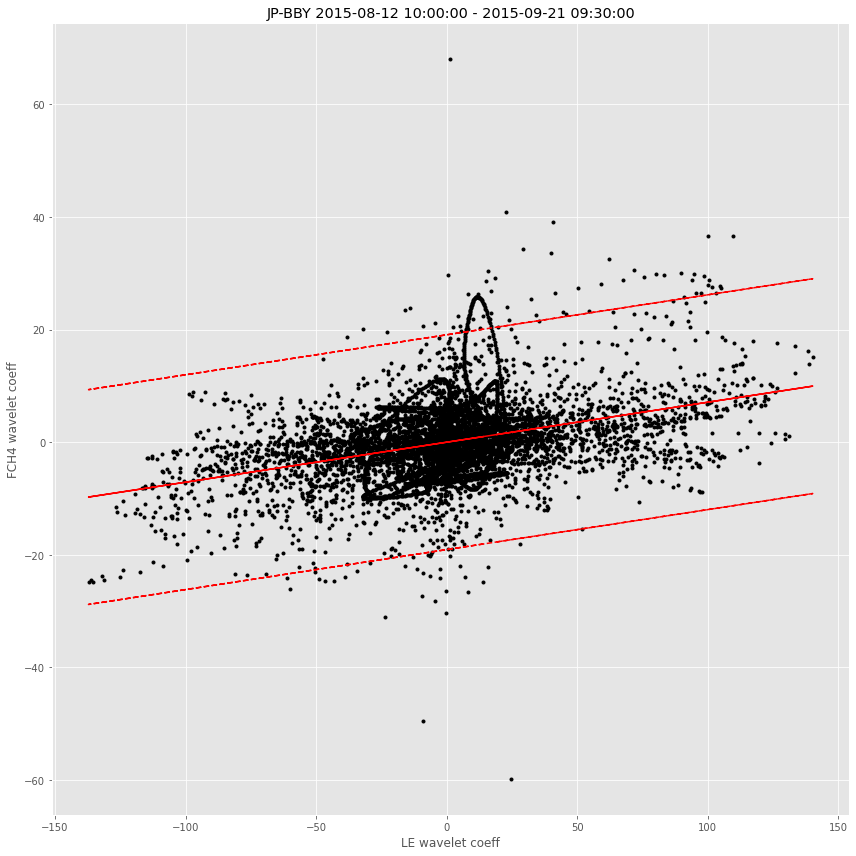

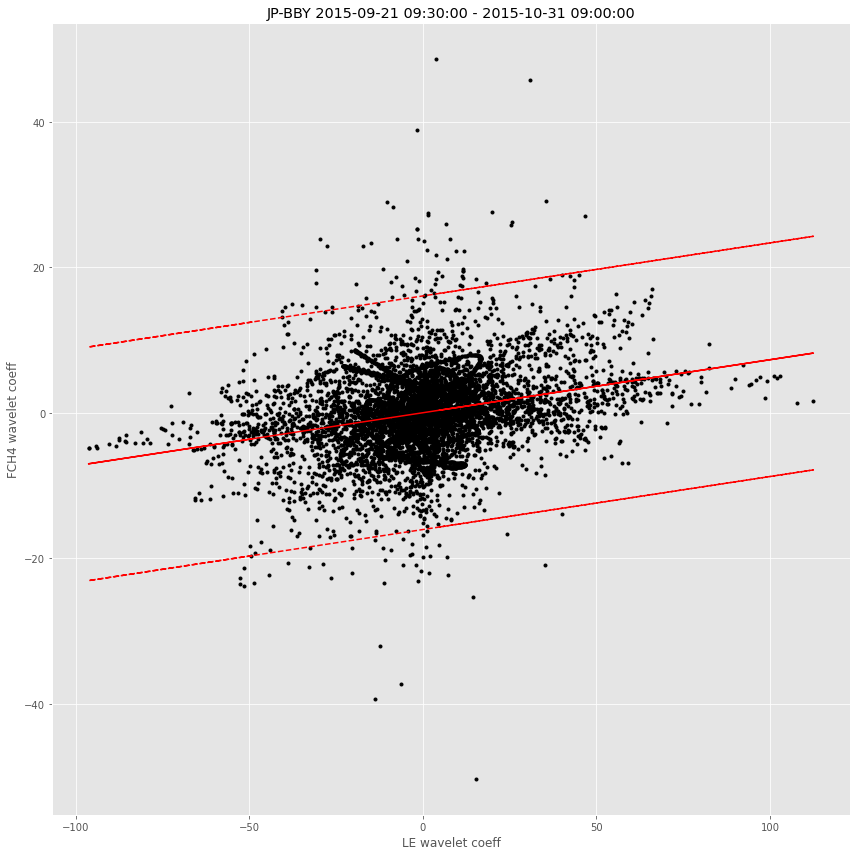

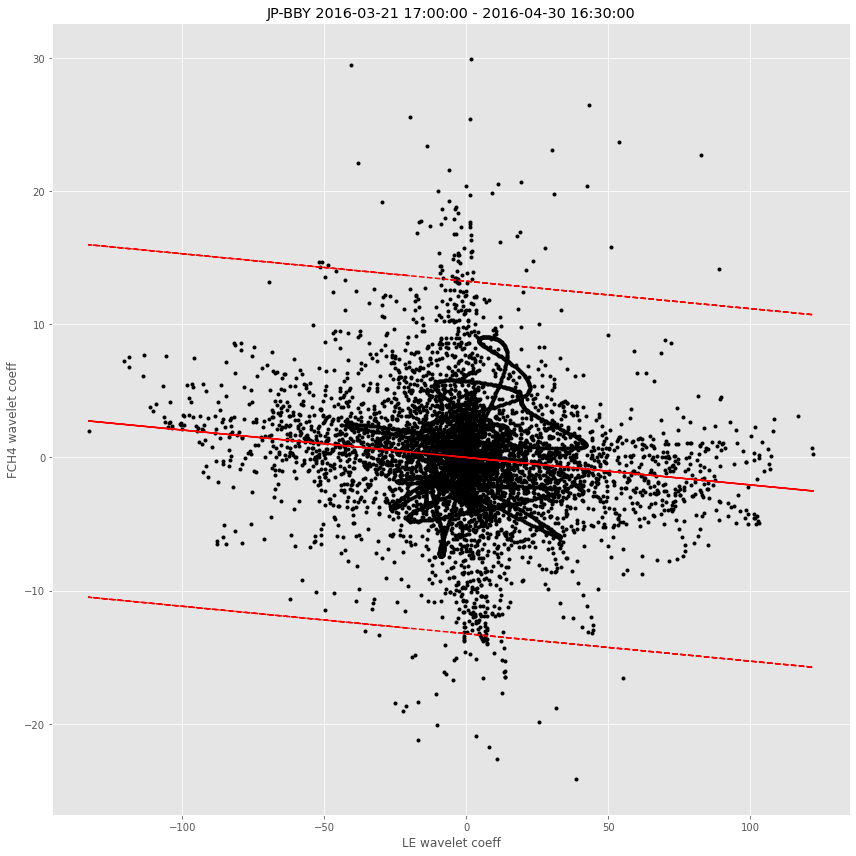

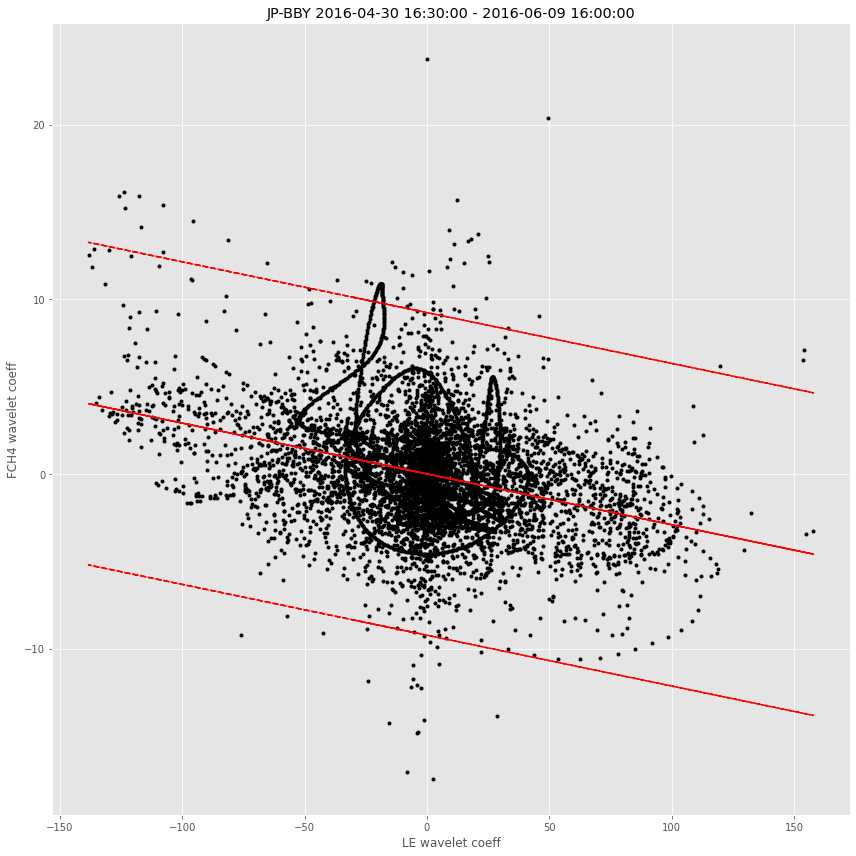

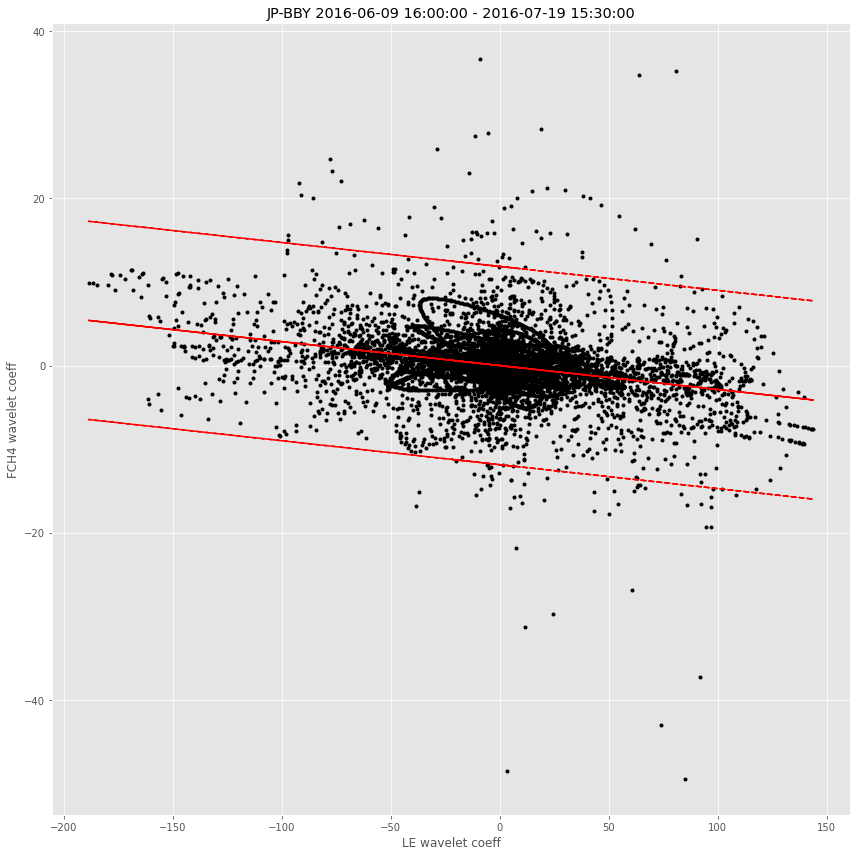

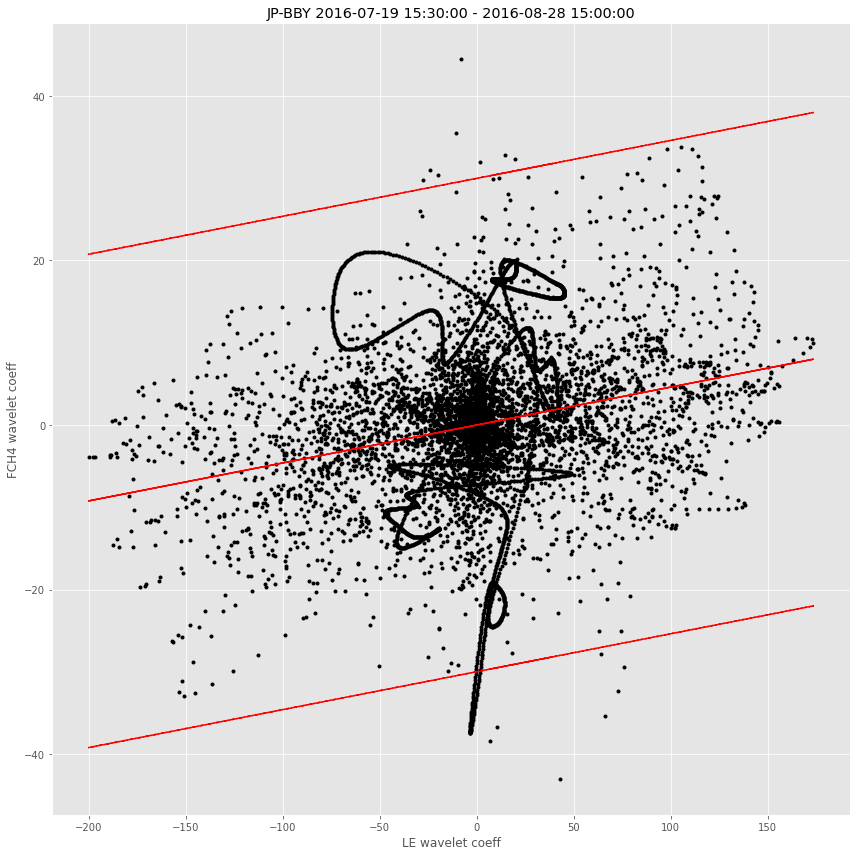

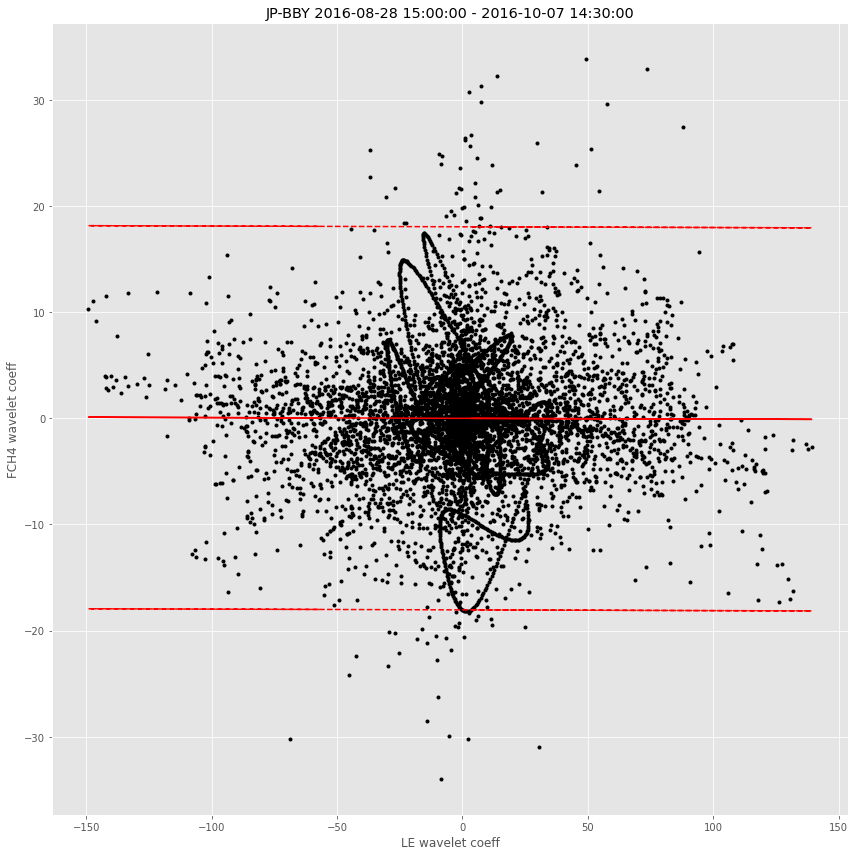

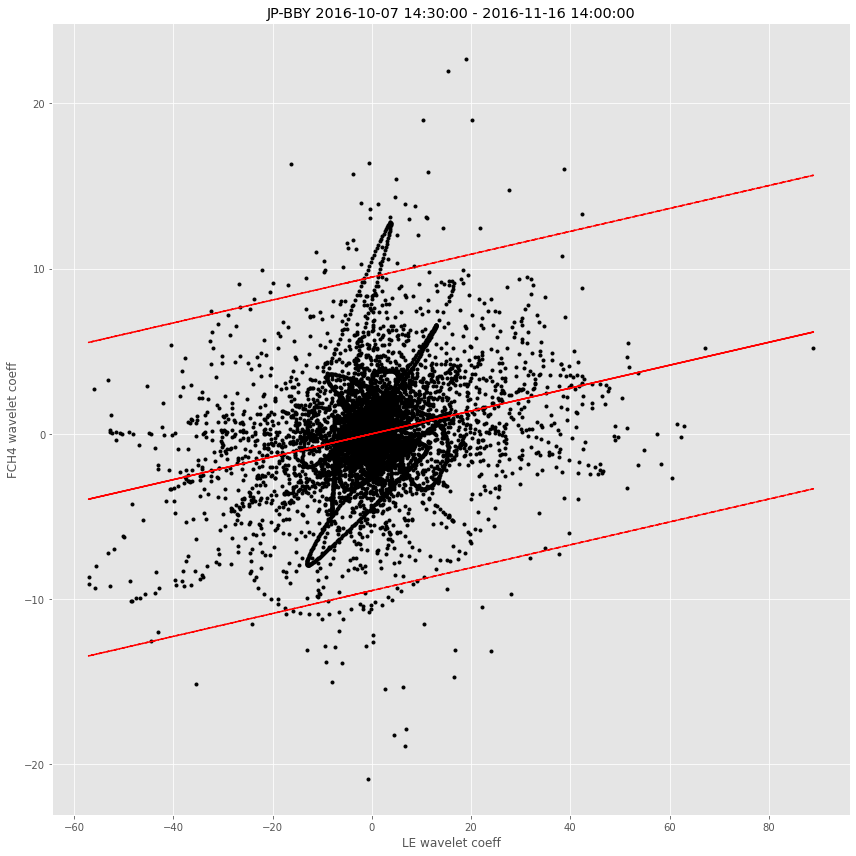

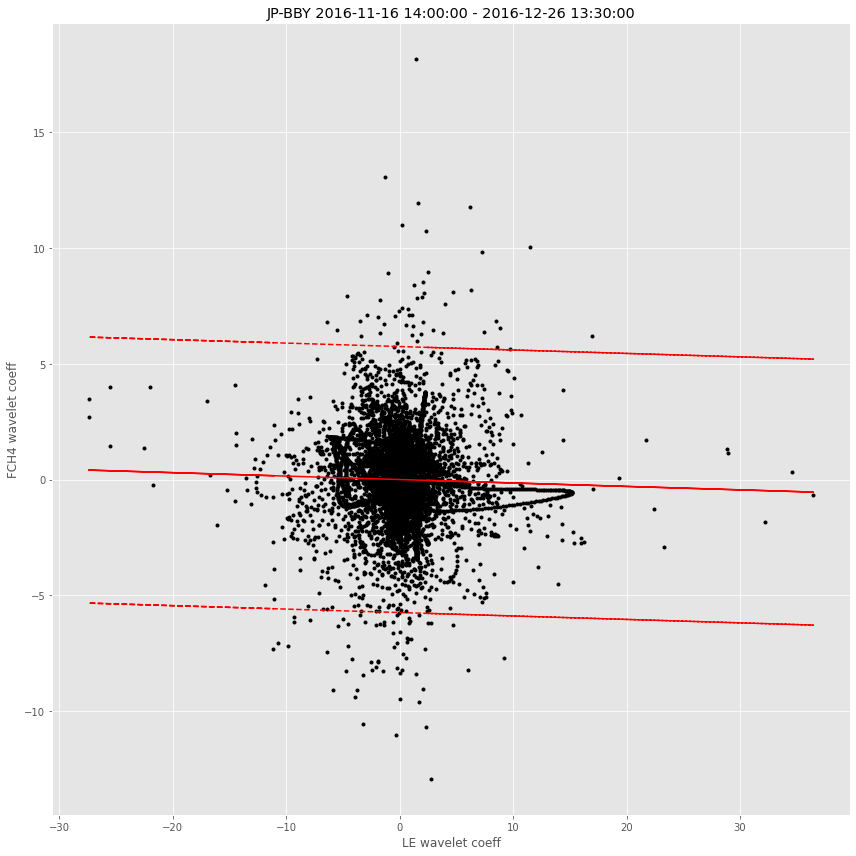

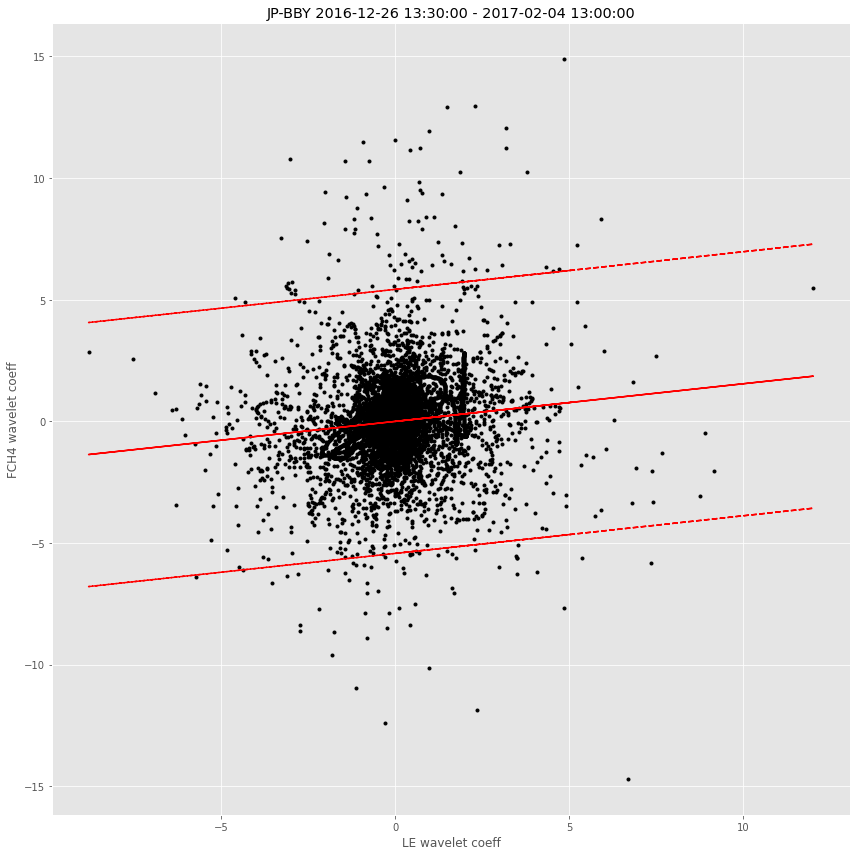

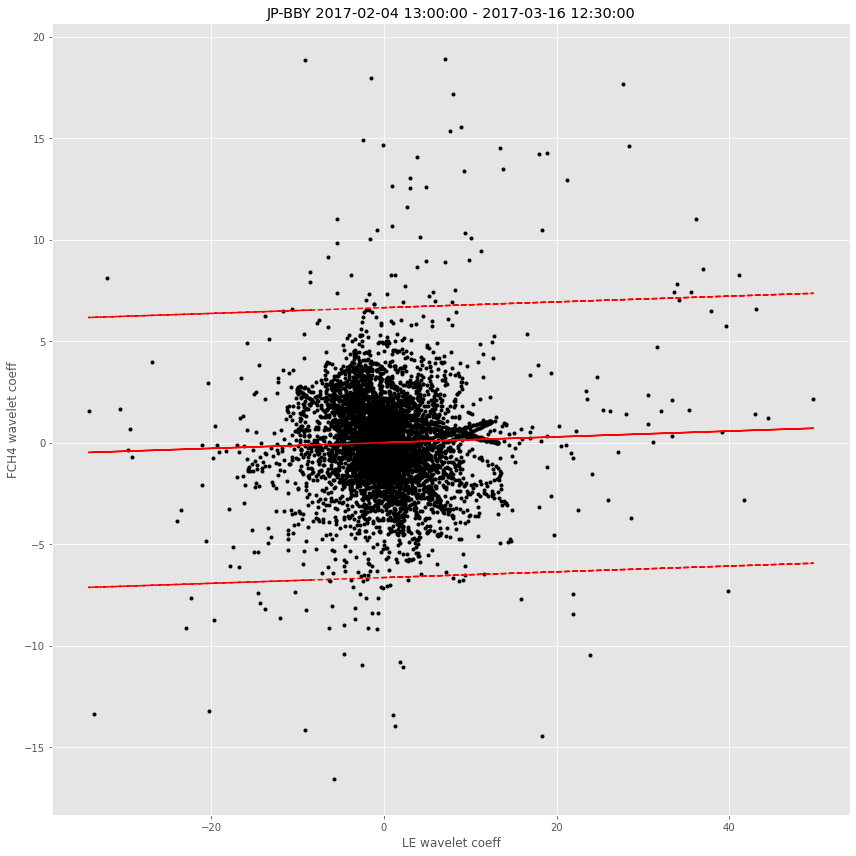

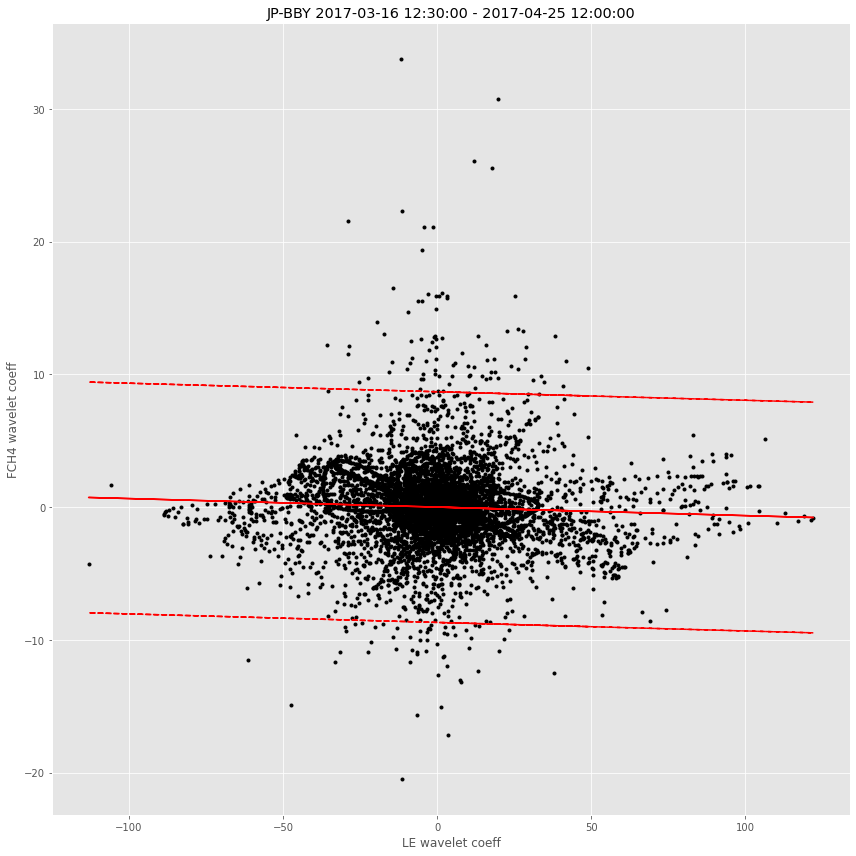

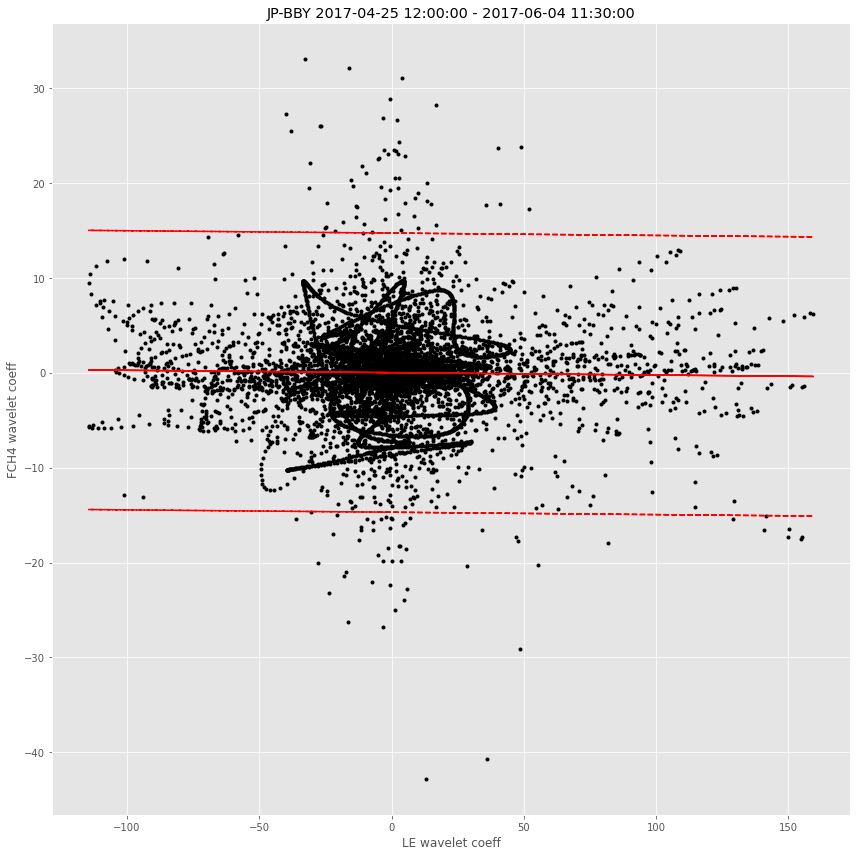

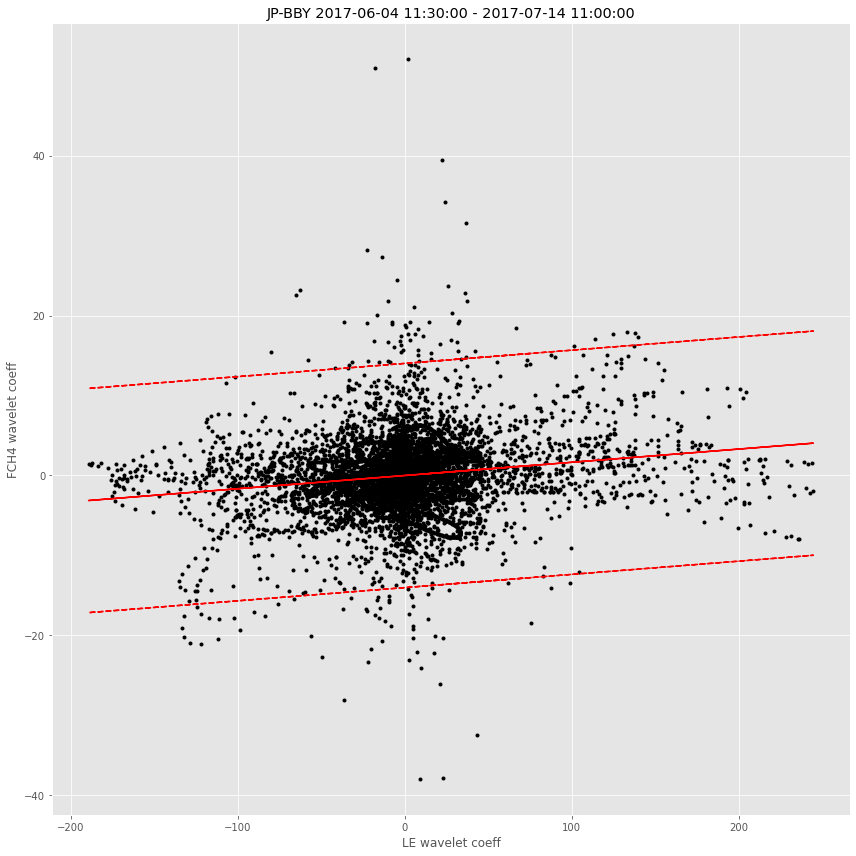

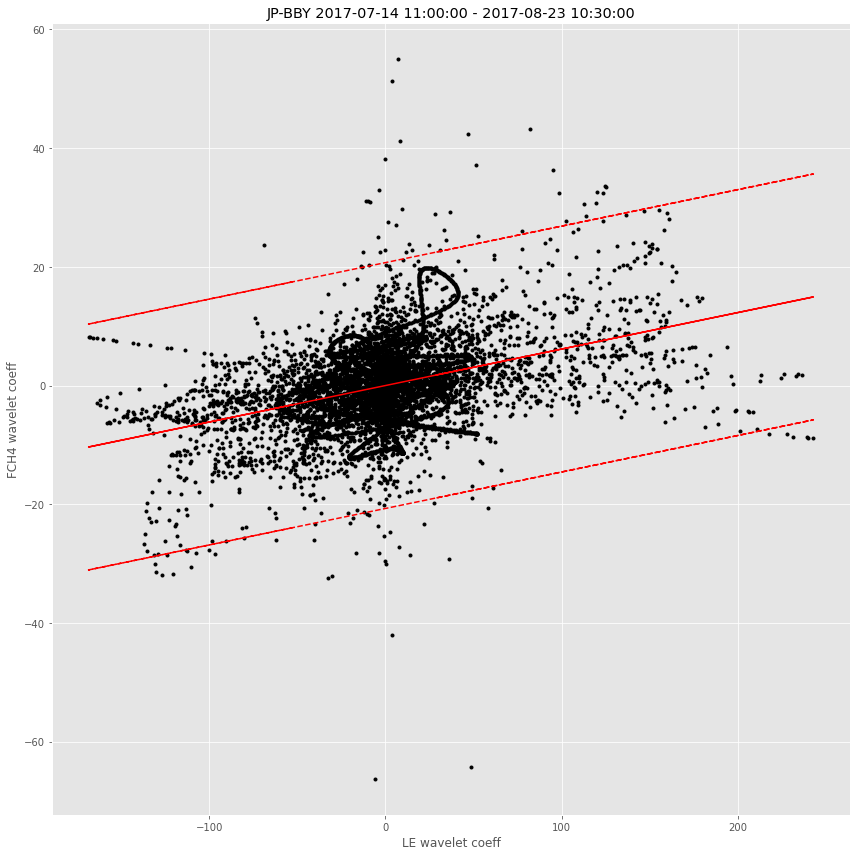

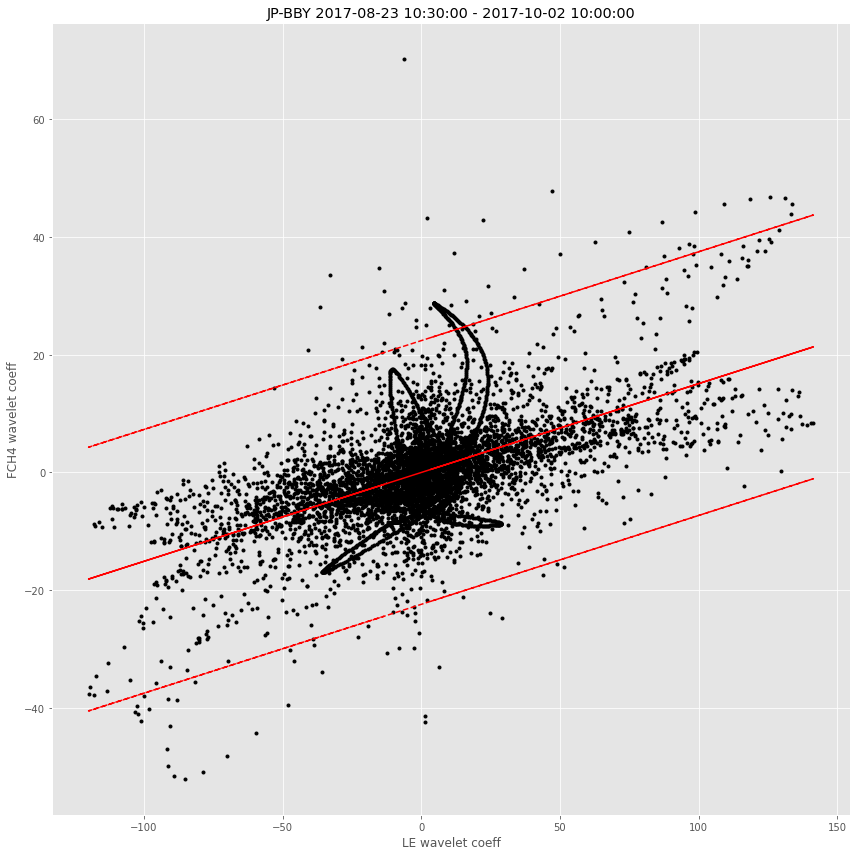

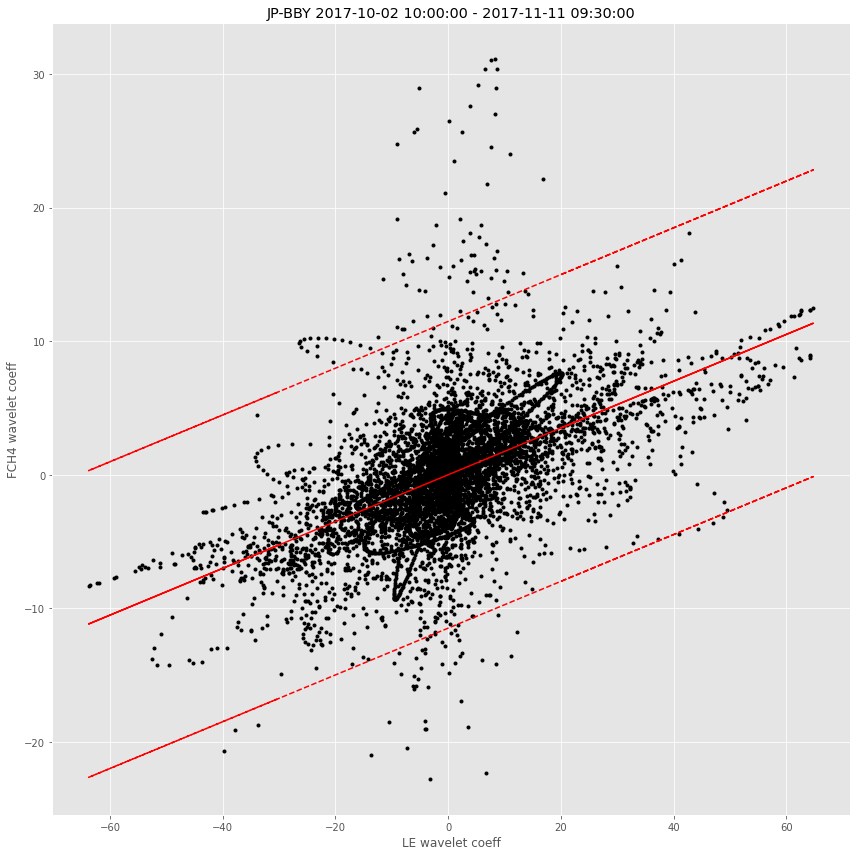

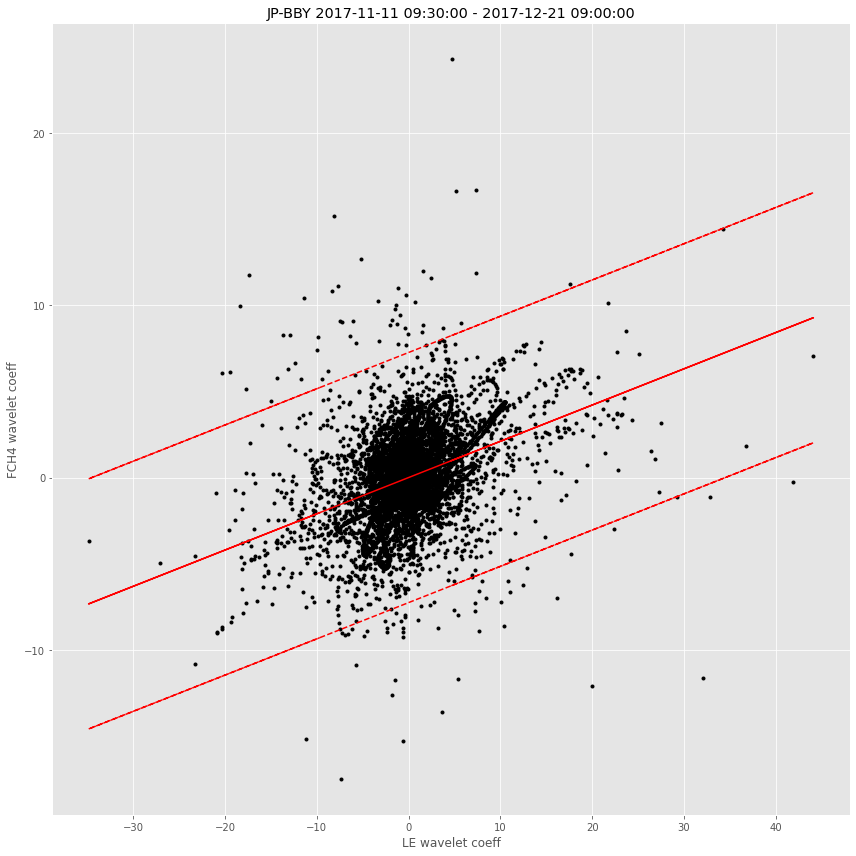

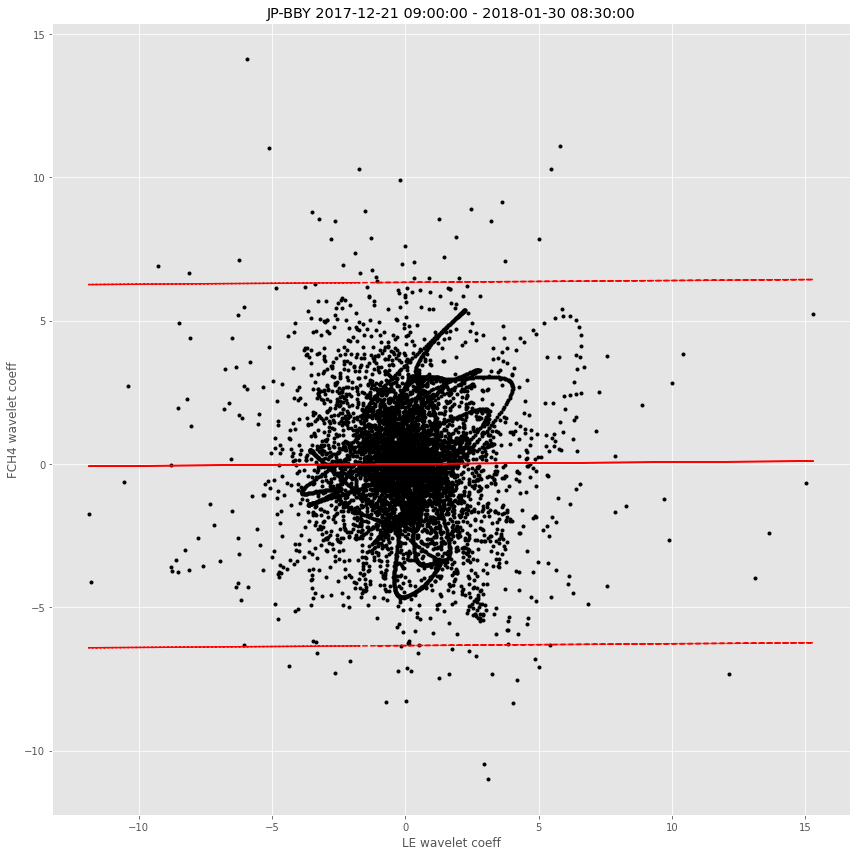

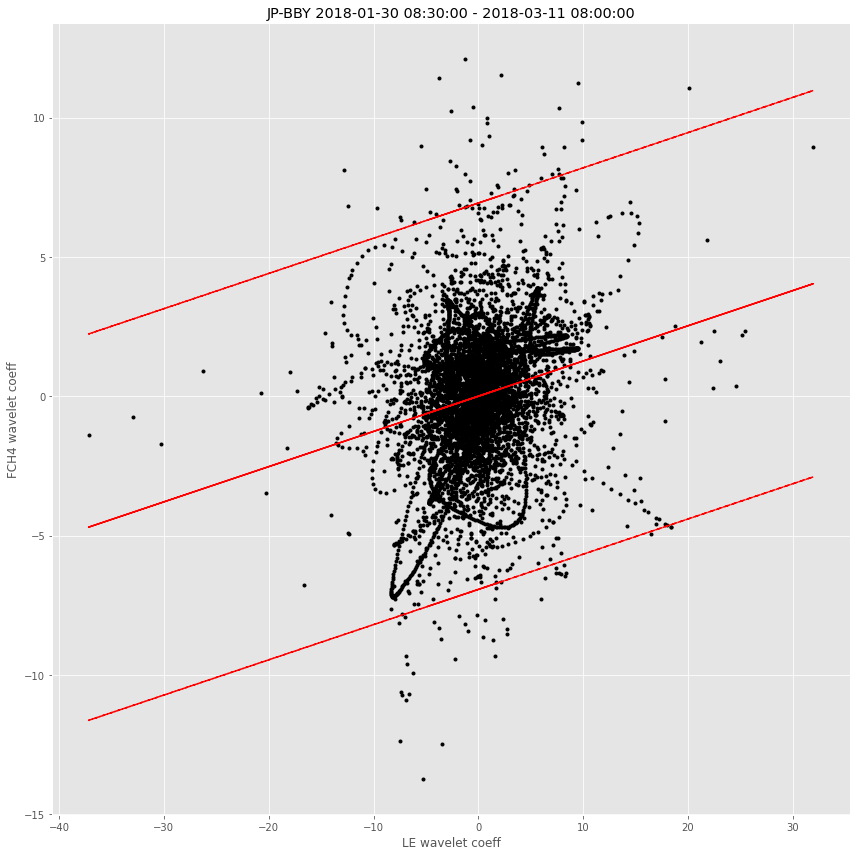

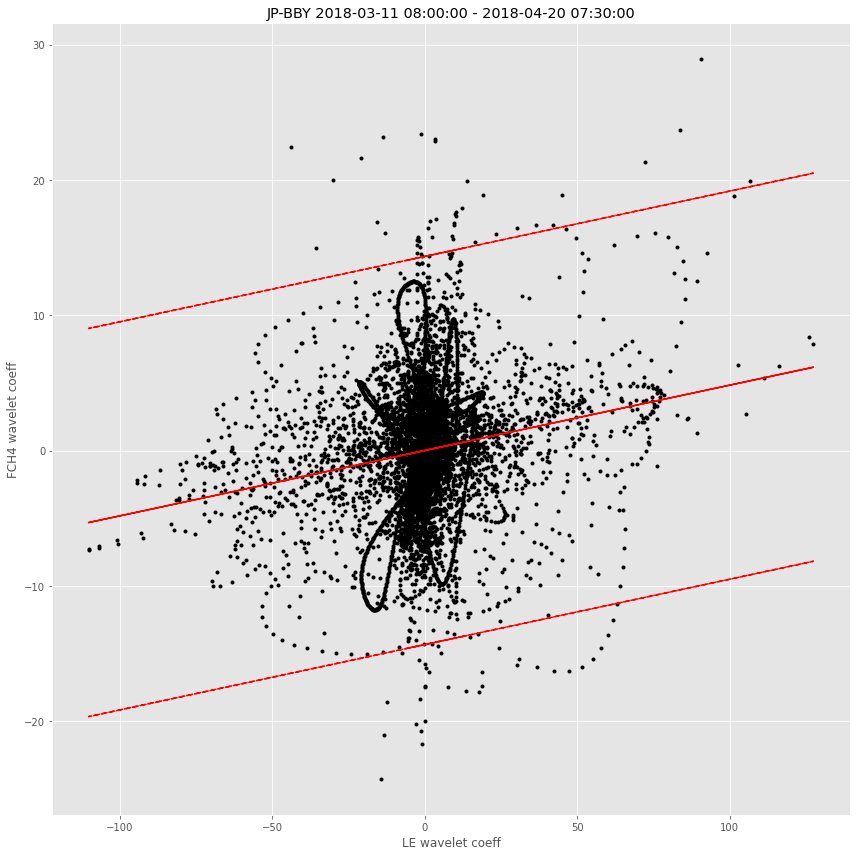

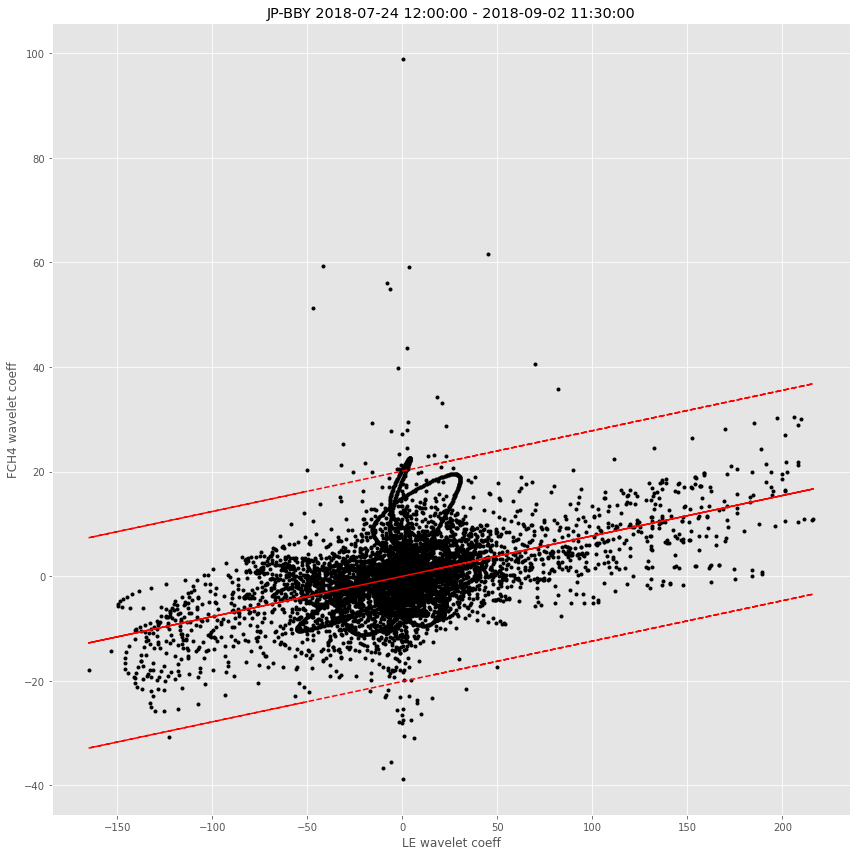

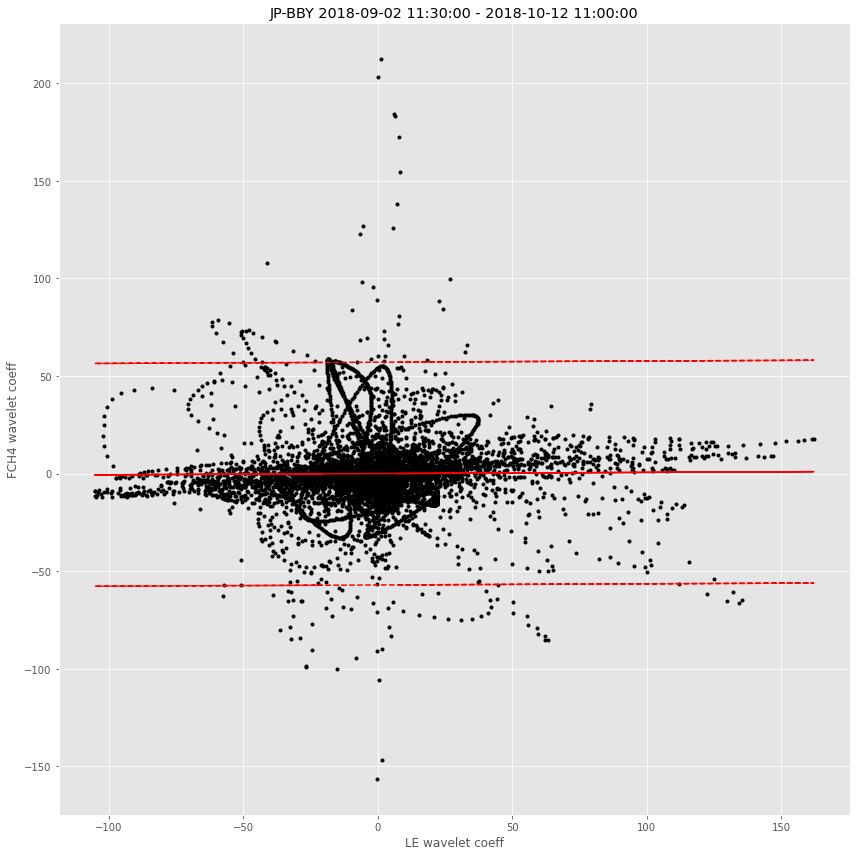

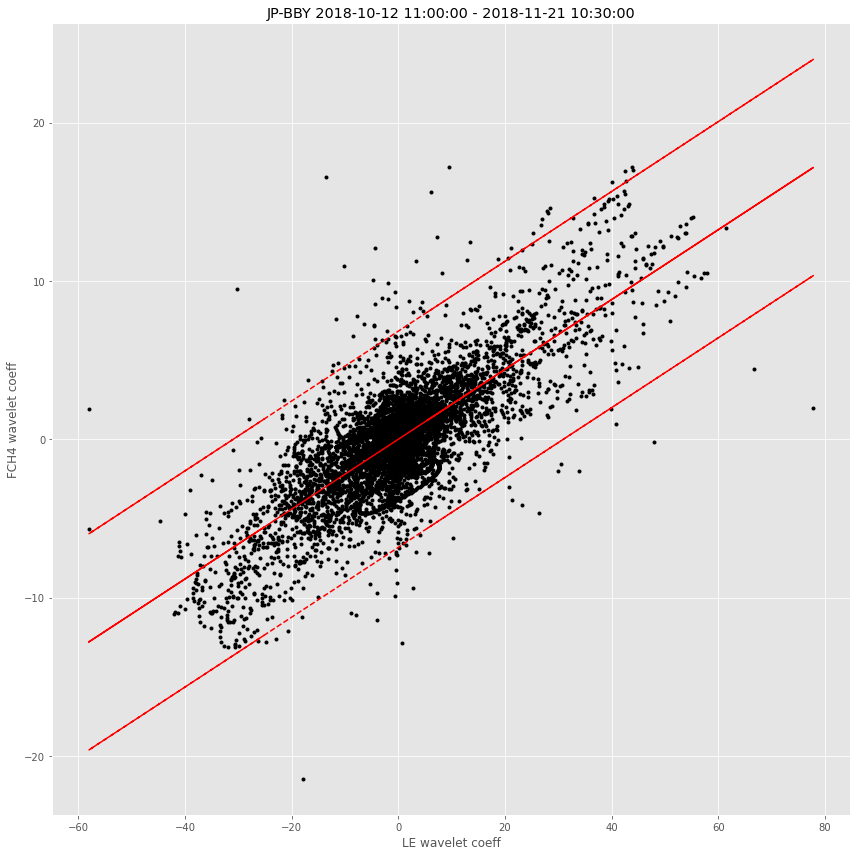

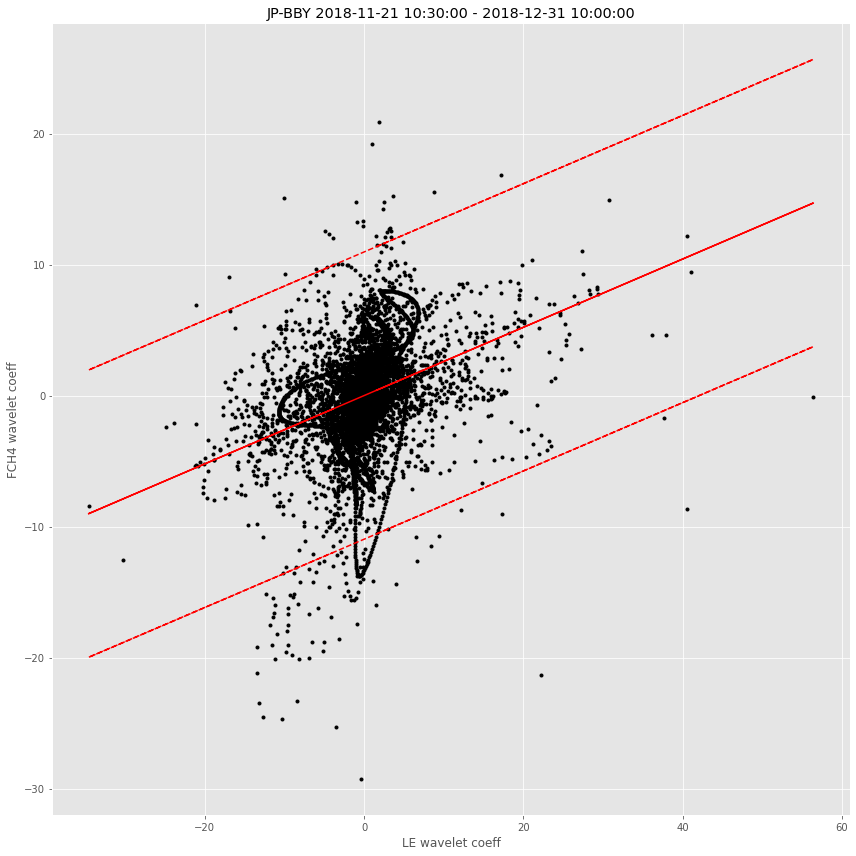

In [10]:
# Scales separated

for window in windows:
    dfw = df.loc[window, :]
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]
    
    
    fig, ax = plt.subplots()
    
    for j in len(Xcols):
        # calc regression
        pred, [Xflat, Yflat], rmsd, r2 = wave.get_regr(dfp, Xcols[j], Ycols[j])
        
        # partition
        dfp = wave.part(dfp, pred, rmsd, r2)
    
    df.loc[dfw.index, 'rmsd'] = dfp.loc[:, 'rmsd'] # write back to df
    df.loc[dfw.index, 'r2'] = dfp.loc[:, 'r2'] # write back to df
    
#     filename = None
    filename = 'plot/20210716/20210716_{}_lump_iwata7_{}_{}.jpeg'.format(site_id, window[0].year, window[0].month)
    
    p.iwata7sep(Xflat, Yflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
           title='{} {} - {}'.format(site_id, window[0], window[-1]), 
             filename = filename)
    
    

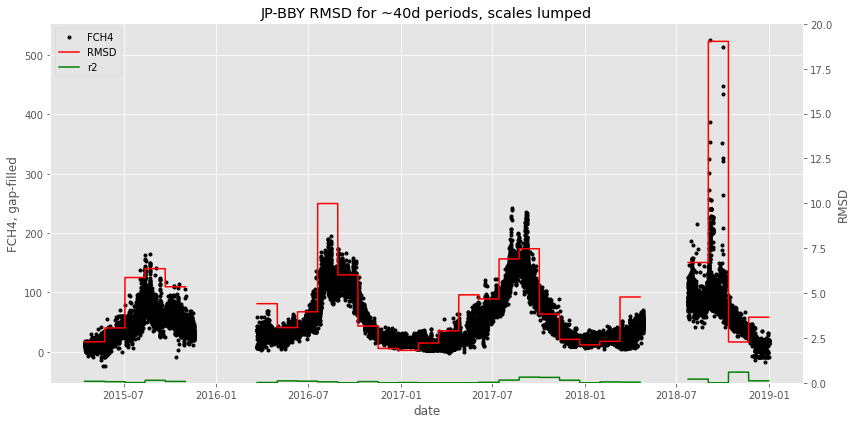

In [11]:
p.date_rmsd(df, title = '{} RMSD for ~40d periods, scales lumped'.format(site_id),
            filename='plot/20210716/20210716_{}_lump_rmsd_vs_date.jpeg'.format(site_id))

## JP-Swl

In [4]:
# df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame
# df = wave.read('FLX_JP-BBY', method='url')

site_id = 'JP-Swl'
df = wave.read('FLX_{}'.format(site_id), method='file')

In [5]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

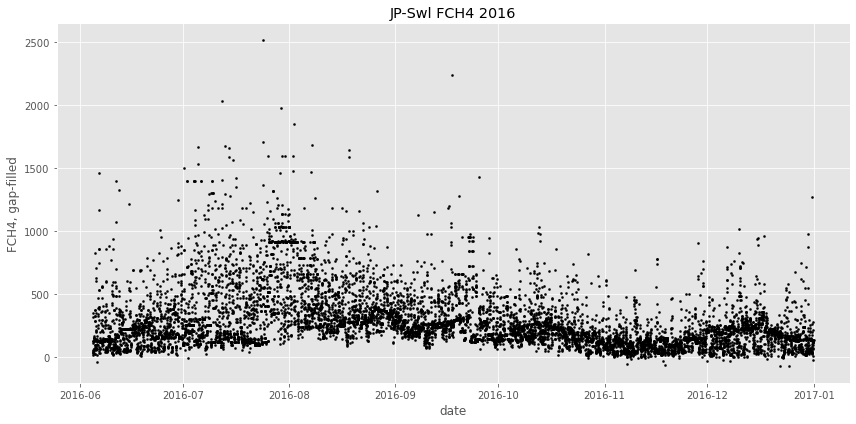

In [7]:
p.date(df.index, df['FCH4_F'], xlabel='date', ylabel='FCH4, gap-filled', title="{} FCH4 2016".format(site_id))

In [8]:
windows = wave.chop(df)

appending window 2016-06-04 16:30:00 to 2016-07-14 16:00:00 to windows
appending window 2016-07-14 16:00:00 to 2016-08-23 15:30:00 to windows
appending window 2016-08-23 15:30:00 to 2016-10-02 15:00:00 to windows
appending window 2016-10-02 15:00:00 to 2016-11-11 14:30:00 to windows
appending window 2016-11-11 14:30:00 to 2016-12-21 14:00:00 to windows


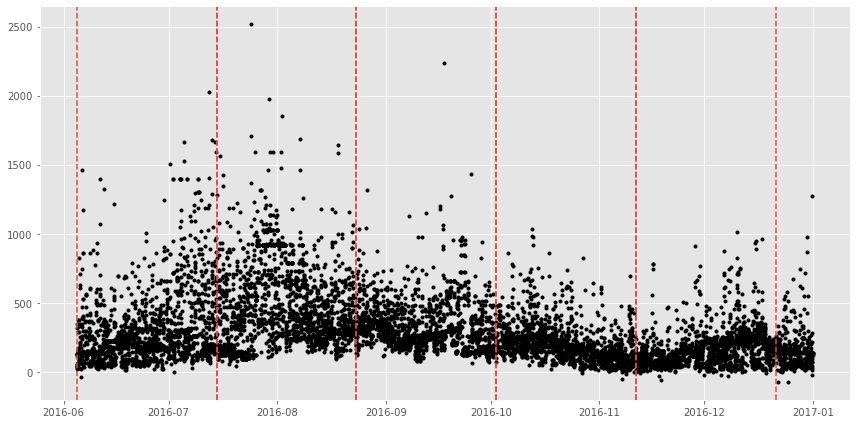

In [9]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df.index, df.loc[df.index, 'FCH4_F'], 'k.')
for w in windows:
    ax.axvline(w[0], ls='--')
    ax.axvline(w[-1], ls='--')

fig.tight_layout()

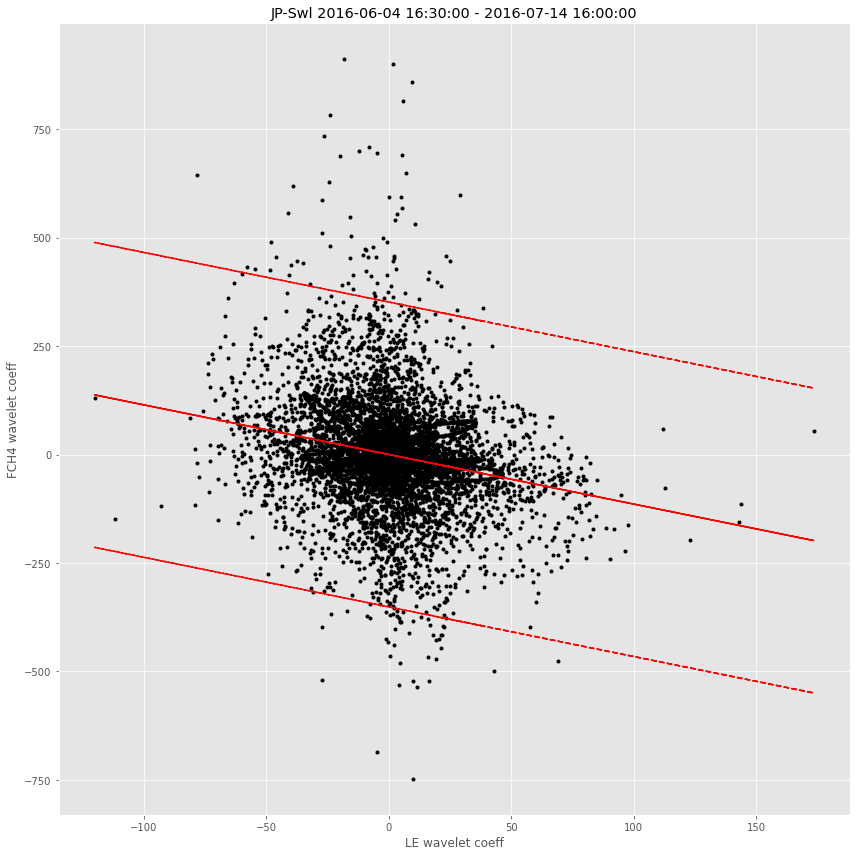

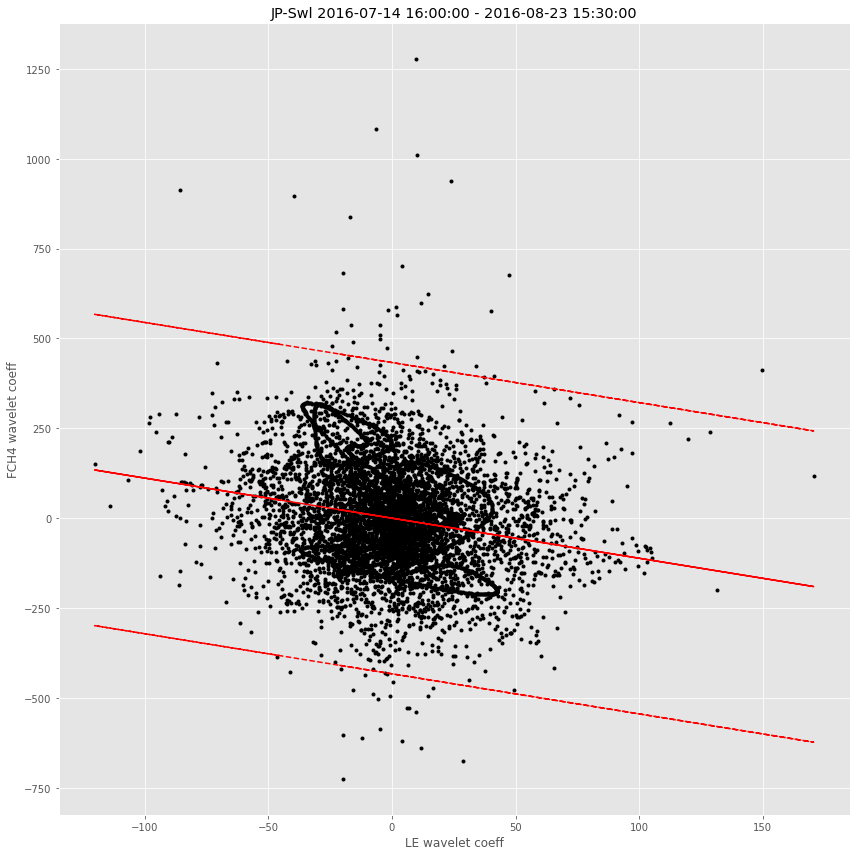

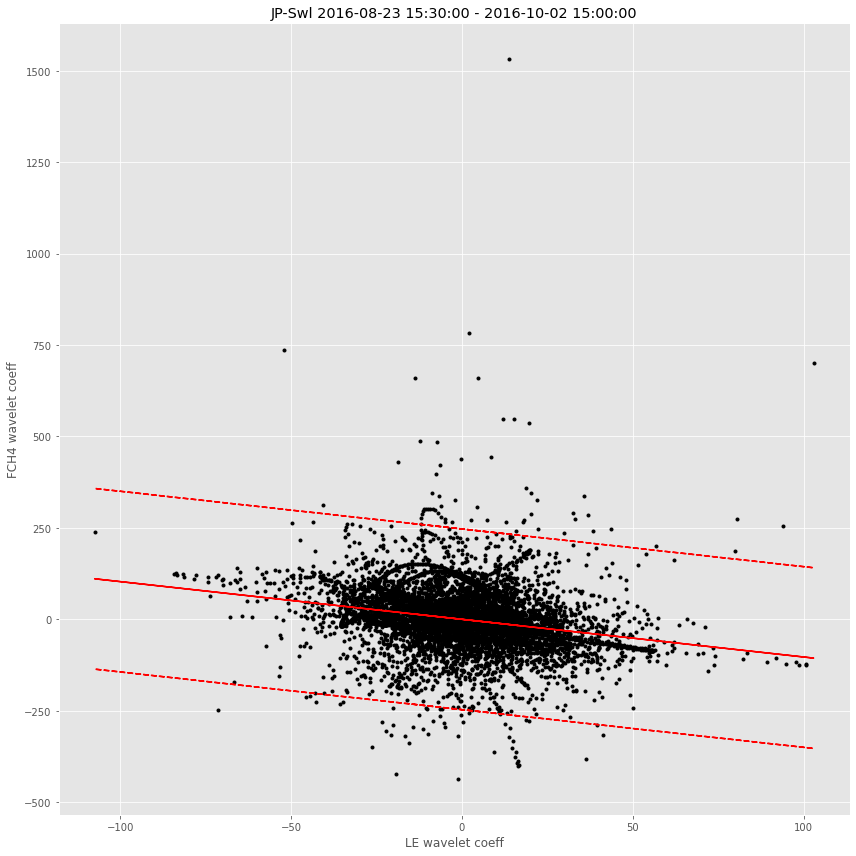

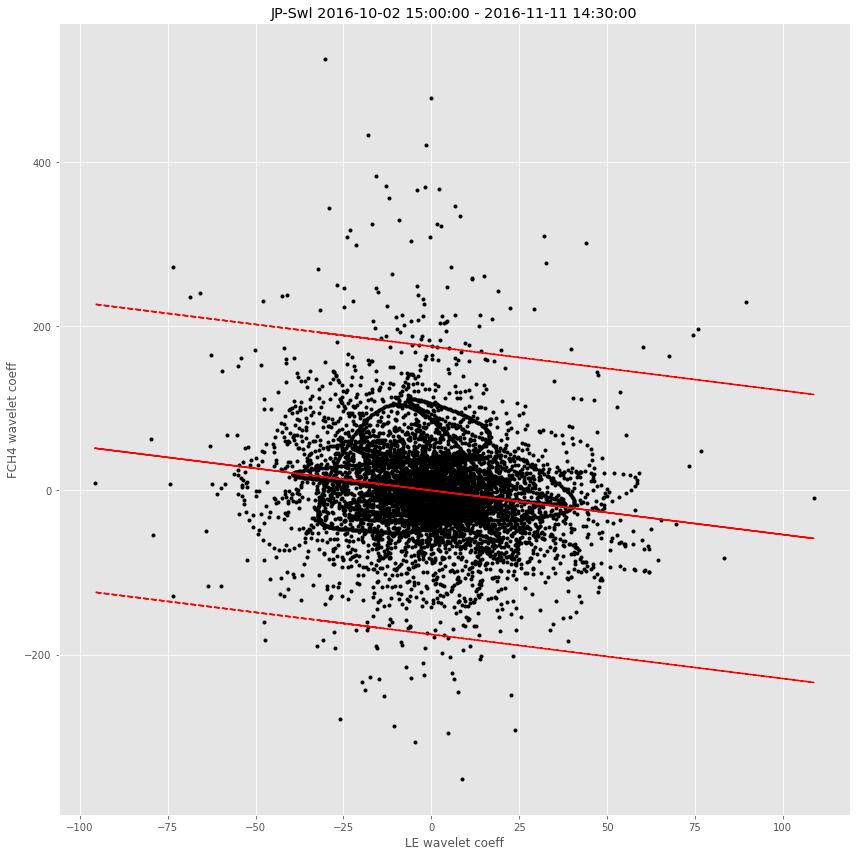

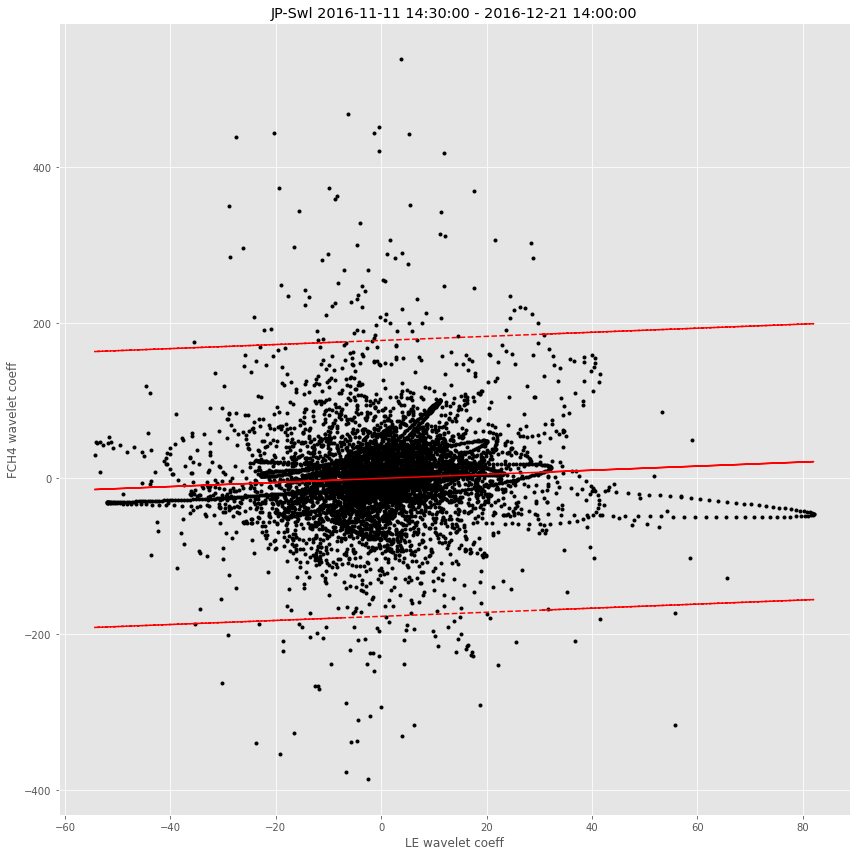

In [10]:
for window in windows:
    dfw = df.loc[window, :]
    dfp = wave.proc(dfw)
    
    # choose columns for partitioning
    Xcols = dfp.columns[dfp.columns.str.startswith('LE_w')]
    Ycols = dfp.columns[dfp.columns.str.startswith('FCH4_w')]
    
    # calc regression
    pred, [Xflat, Yflat], rmsd, r2 = wave.get_regr(dfp, Xcols, Ycols)
    
    # partition
    dfp = wave.part(dfp, pred, rmsd, r2)
    
#     filename = None
    filename = 'plot/20210716/20210716_{}_lump_iwata7_{}_{}.jpeg'.format(site_id, window[0].year, window[0].month)
    
    p.iwata7(Xflat, Yflat, pred, rmsd, xlabel='LE wavelet coeff', ylabel='FCH4 wavelet coeff', 
           title='{} {} - {}'.format(site_id, window[0], window[-1]), 
             filename = filename)
    
    df.loc[dfw.index, 'rmsd'] = dfp.loc[:, 'rmsd'] # write back to df
    df.loc[dfw.index, 'r2'] = dfp.loc[:, 'r2'] # write back to df

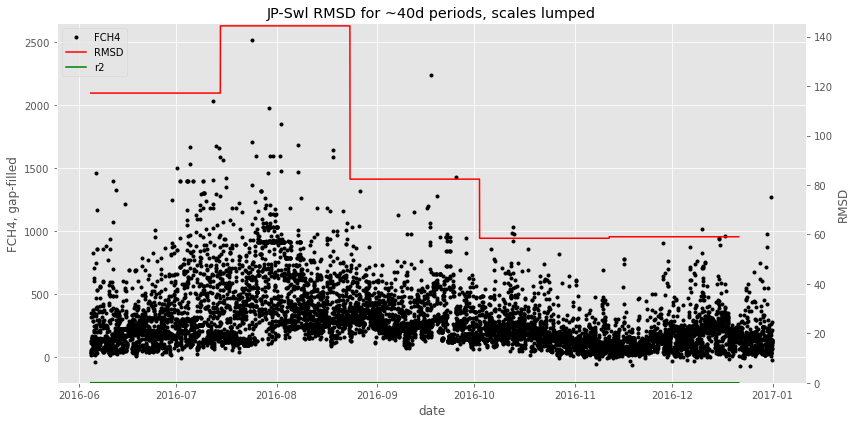

In [11]:
p.date_rmsd(df, title = '{} RMSD for ~40d periods, scales lumped'.format(site_id),
            filename='plot/20210716/20210716_{}_lump_rmsd_vs_date.jpeg'.format(site_id))